In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pymc3 as pm
import arviz as az

from math import log10, floor

useratiodata=0 #1 for Scenario B to incorporate ratio data, 0 otherwise
sigmadeterministic=1 #0 to assign Inverse Gamma prior on variance of noise variables, otherwise plug in estimates will be used. 

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
dataflows = pd.read_csv("data/aluminiumflow.txt",comment='#')
datastocks = pd.read_csv("data/aluminiumstock.txt",comment='#')

from preprocessingagg import preprocessing, createdesignmatrix, createratiomatrix, createcompactmatrix, createcompactratiomatrix
from prior import round_to_poweroften, definepriors
from model import mfamodel
from posteriorpredictive import filelabeler, ppplots, ppplotsratiodata, top10hdi

availabledatafull, dataparentstockneededcols, dataparentflowsneededcols, processnamesdict, allflownumbersmatrix, m, N=preprocessing(datastocks,dataflows)

#construct the prior

dataflowspriors = pd.read_csv("data/aluminiumflowsprior.txt",comment='#')
datastockspriors = pd.read_csv("data/aluminiumstocksprior.txt",comment='#')


priormean,covariancevec,truevalues=definepriors(datastockspriors, dataflowspriors, availabledatafull, m, N)

#construct design matrix

designmatrix,datavector,availablechildstocksandflows,zerostocksandflows,stockindex,flowindex,CoMindex=createdesignmatrix(availabledatafull, dataparentstockneededcols, dataparentflowsneededcols, m, N)

#construct matrices for flow ratio data

dataratios = pd.read_csv("data/aluminiumratio.txt",comment='#')
ratiovector,ratiomatrixtop,ratiomatrixbottom,availablechildstocksandflows=createratiomatrix(dataratios, m, N, availablechildstocksandflows)


#set function assures uniqueness of the variables selected
availablechildstocksandflows=sorted(list(set(availablechildstocksandflows)))

zerostocksandflows=sorted(list(set(zerostocksandflows)))

availablechildstocksandflows = [x for x in availablechildstocksandflows if x not in zerostocksandflows]


availablechildstocks = [i for i in availablechildstocksandflows if i < m]
availablechildflows = [i for i in availablechildstocksandflows if i >= m]

availablechildstocksnames=[processnamesdict[str(x)] for x in availablechildstocks]

#subset of designmatrix for stocks and flows which actually exist in the system/are non zero.
designmatrixcompact,designmatrixstockscompact,designmatrixflowscompact=createcompactmatrix(designmatrix,availablechildstocksandflows,m)

ratiomatrixtopstockscompact,ratiomatrixtopflowscompact,ratiomatrixbottomstockscompact,ratiomatrixbottomflowscompact=createcompactratiomatrix(ratiomatrixtop,ratiomatrixbottom,availablechildstocksandflows,m)

priormeancompact = priormean[availablechildstocksandflows]
covarianceveccompact = covariancevec[availablechildstocksandflows]
priorcovariancecompact = np.diag(covarianceveccompact)

truevaluescompact=truevalues[availablechildstocksandflows]   

In [3]:
#run the Bayesian model

trace, model=mfamodel(priormean, covariancevec, designmatrix,ratiomatrixtop, \
                   ratiomatrixbottom, datavector, ratiovector, availablechildstocksandflows, m, \
                   stockindex, flowindex, CoMindex,useratiodata,sigmadeterministic)

WARNING (theano.tensor.opt): Optimization Warning: The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [flows, stocks]


Sampling 2 chains for 2_000 tune and 10_000 draw iterations (4_000 + 20_000 draws total) took 761 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [4]:
#summary of samples including rhat values for each posterior variable

az.summary(trace).round(2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
stocks[0]     -37.54  1.42  -40.19   -34.86       0.02     0.01    5916.0   
stocks[1]       8.60  0.58    7.47     9.65       0.00     0.00   16317.0   
stocks[2]       9.46  1.32    7.00    11.97       0.02     0.01    7213.0   
stocks[3]       3.24  1.15    1.08     5.36       0.01     0.01    7359.0   
stocks[4]       0.11  0.40   -0.63     0.85       0.00     0.00   25143.0   
...              ...   ...     ...      ...        ...      ...       ...   
datavars[97]   -0.05  0.48   -0.96     0.84       0.00     0.00   20570.0   
datavars[98]   -0.21  0.37   -0.91     0.46       0.00     0.00   23359.0   
datavars[99]   -0.18  0.14   -0.44     0.06       0.00     0.00   22935.0   
datavars[100]  -0.02  0.50   -0.97     0.92       0.00     0.00   31091.0   
datavars[101]  -0.02  0.50   -0.94     0.93       0.00     0.00   33287.0   

               ess_tail  r_hat  
stocks[0]        9842.0    1.0  
stocks[1]       15169.0    1.0  
stocks[2]        8879.0    1.0  
stocks[3]        7165.0    1.0  
stocks[4]       14917.0    1.0  
...                 ...    ...  
datavars[97]    17255.0    1.0  
datavars[98]    16859.0    1.0  
datavars[99]    17790.0    1.0  
datavars[100]   17411.0    1.0  
datavars[101]   15741.0    1.0  

[281 rows x 9 columns]

<Figure size 432x288 with 0 Axes>

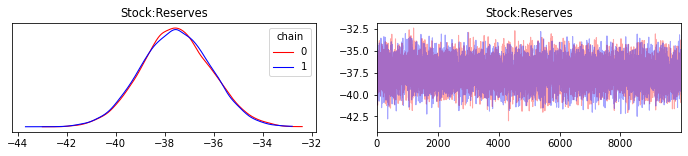

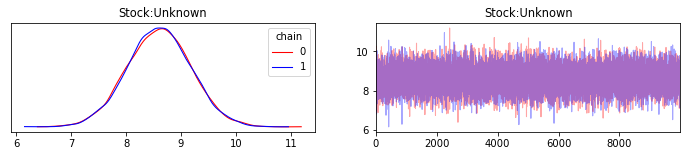

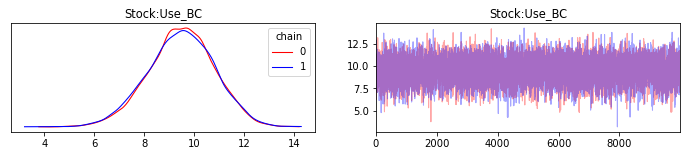

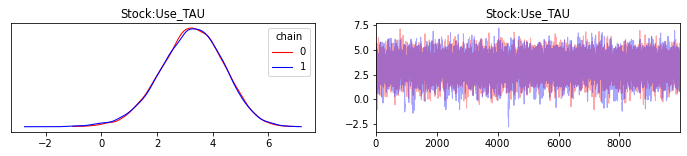

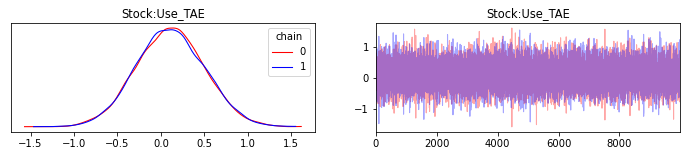

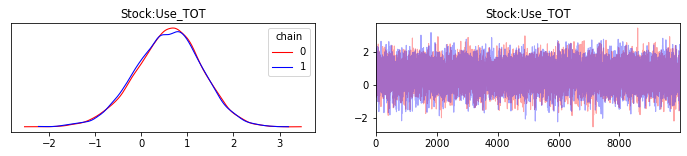

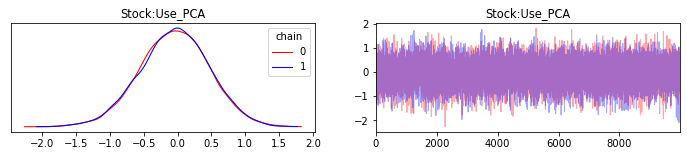

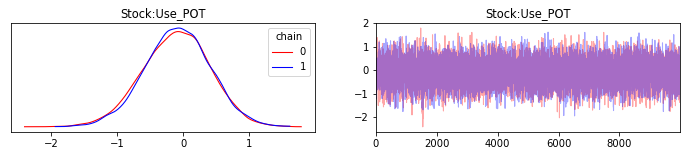

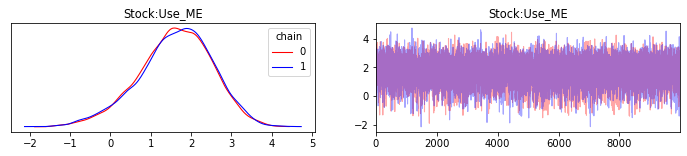

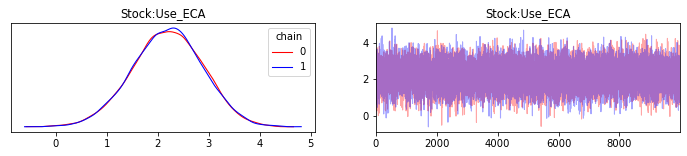

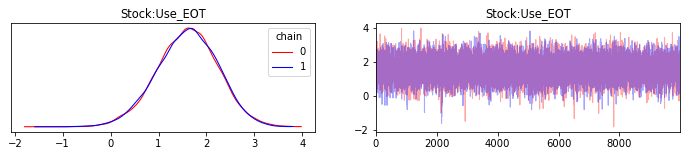

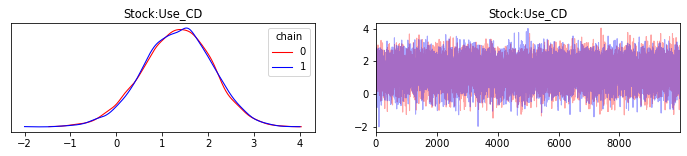

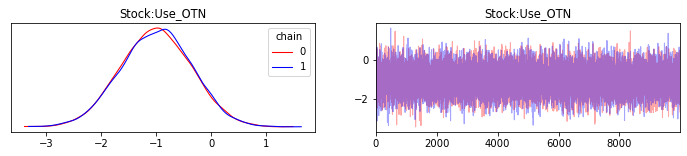

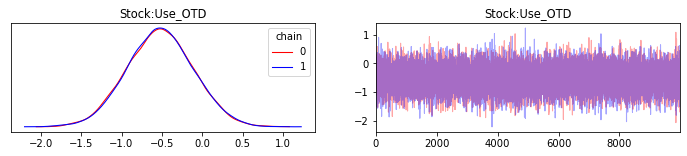

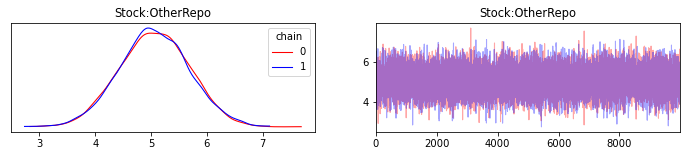

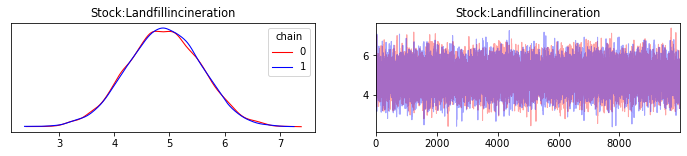

In [5]:
#generate traceplots for the change in stock variables

labels=[processnamesdict[str(x)] for x in availablechildstocks]

import arviz.labels as azl

plt.tight_layout()
for i in range(0,len(labels)):
    
    labeller = azl.MapLabeller(var_name_map={"stocks": r"Stock"+":"+labels[i]})
    
    posteriorstocktraceplots=az.plot_trace(trace, var_names="stocks",compact=True,show=True,backend="matplotlib", coords={'stocks_dim_0': [i]},labeller=labeller,legend=True,chain_prop={"color": ['r', 'b']})

    posteriorstocktraceplots[0,0].get_figure().savefig("outputgraphstrace"+filelabeler(useratiodata)+"/"+"Stocktrace"+"_"+labels[i]+filelabeler(useratiodata)+".pdf")

<Figure size 432x288 with 0 Axes>

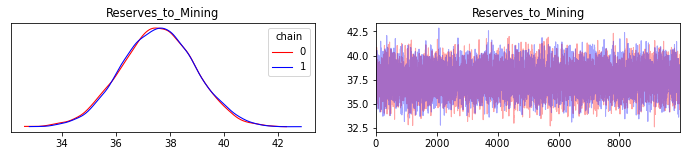

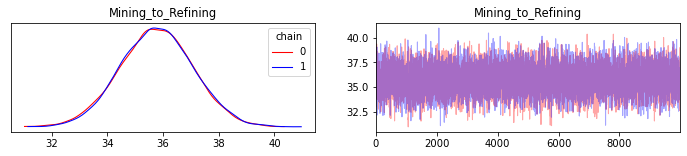

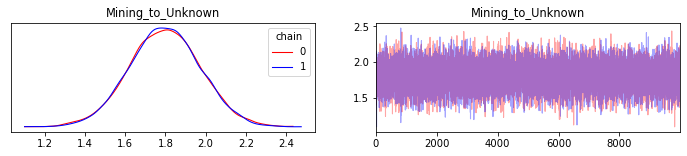

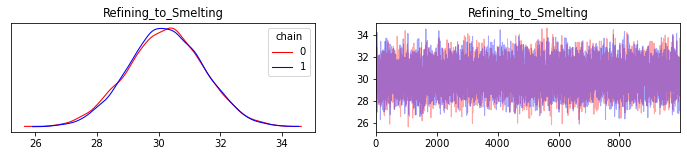

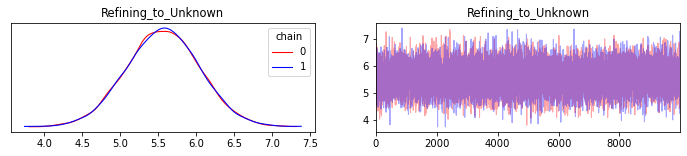

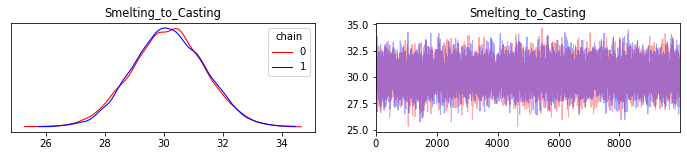

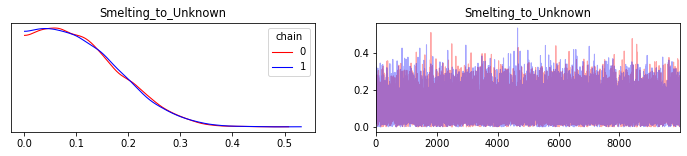

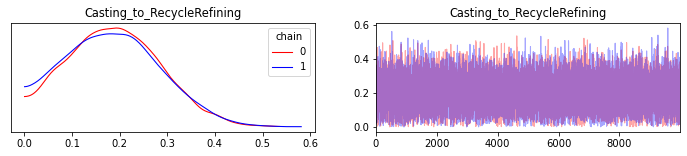

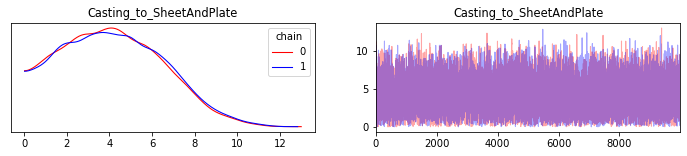

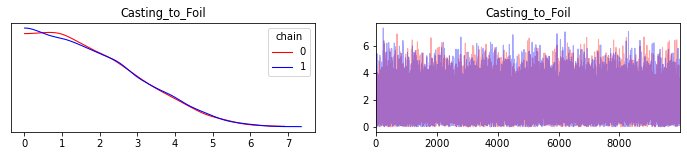

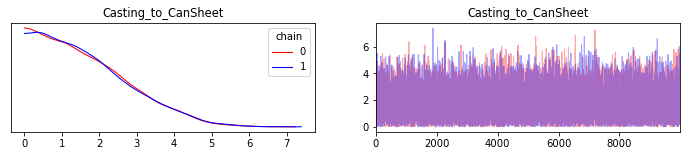

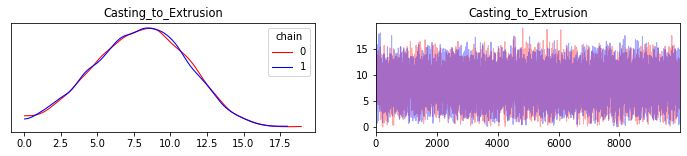

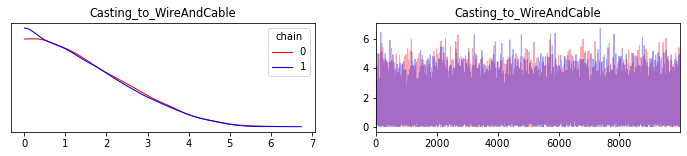

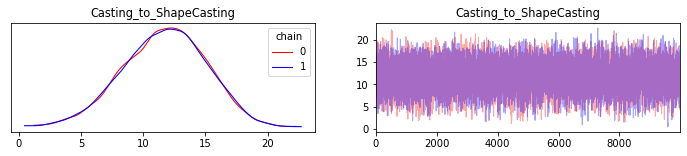

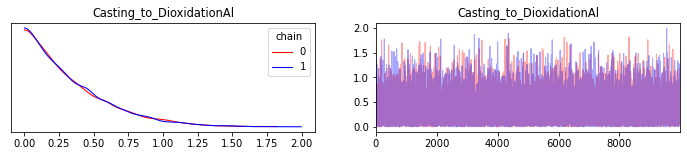

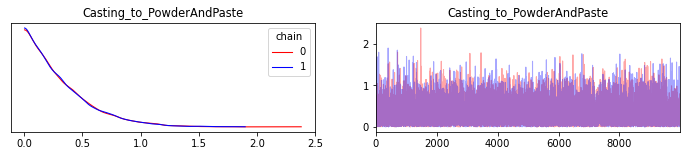

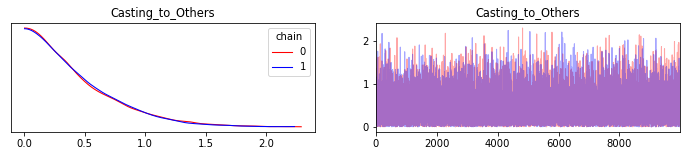

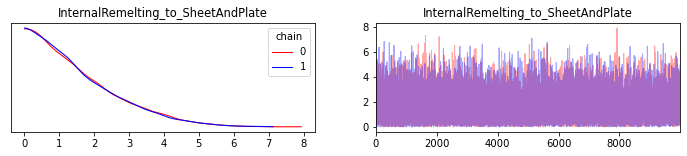

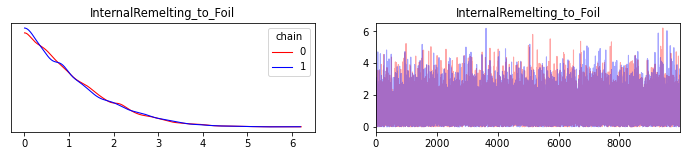

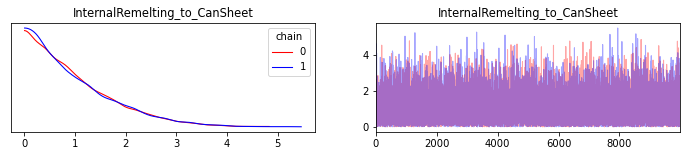

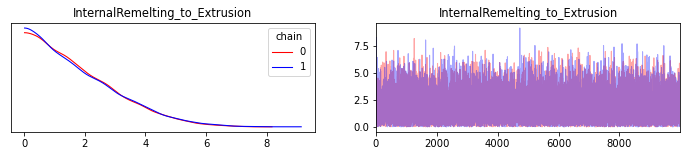

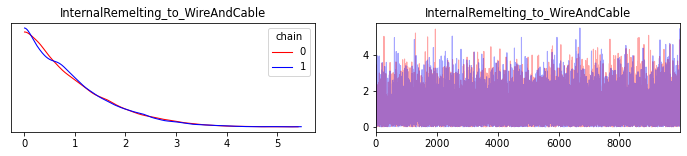

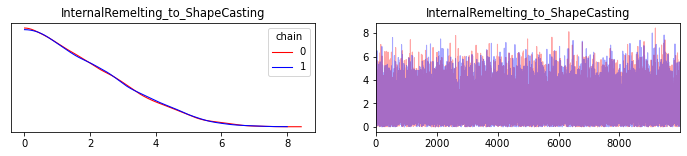

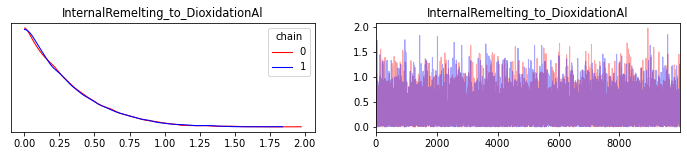

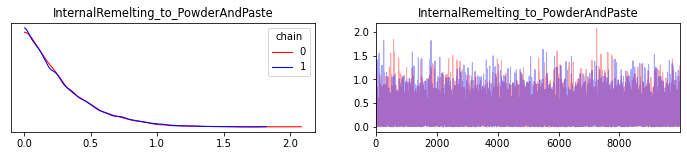

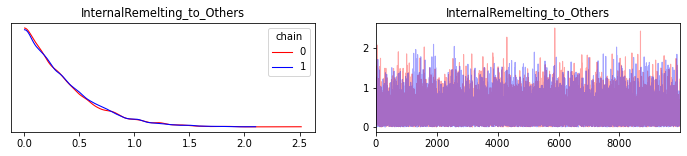

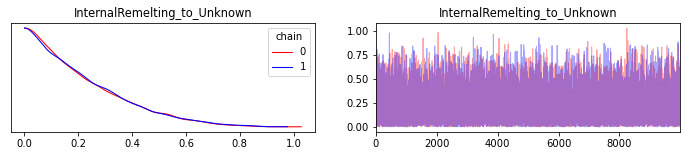

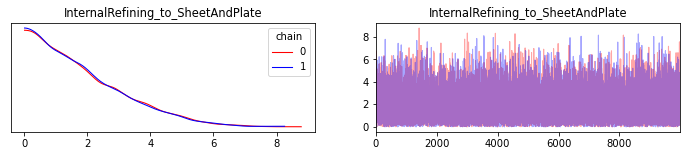

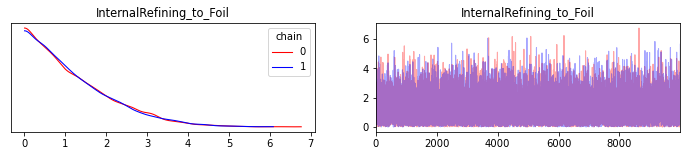

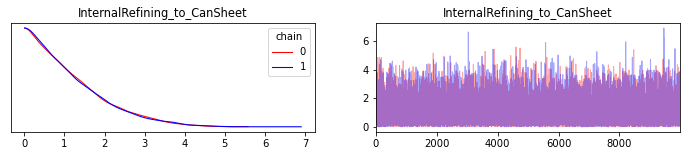

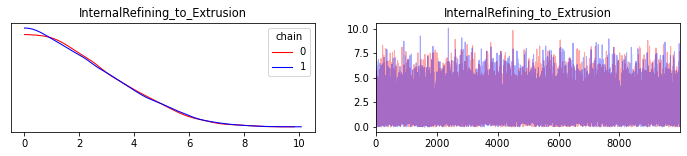

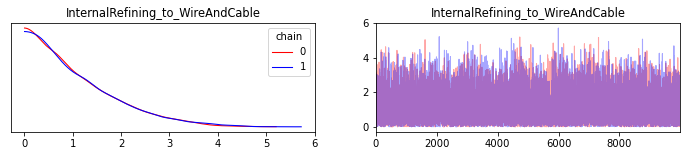

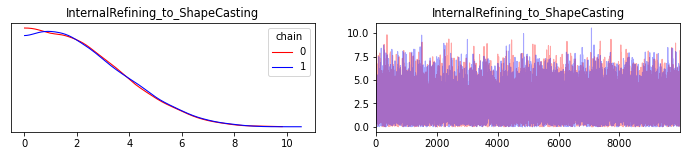

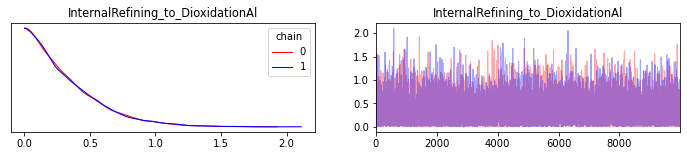

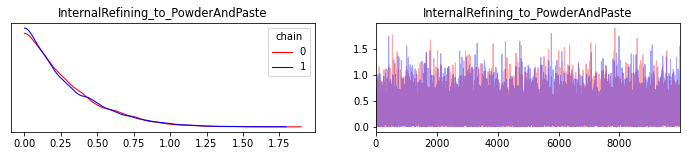

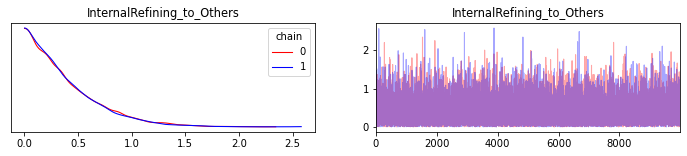

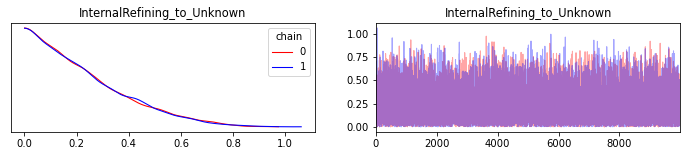

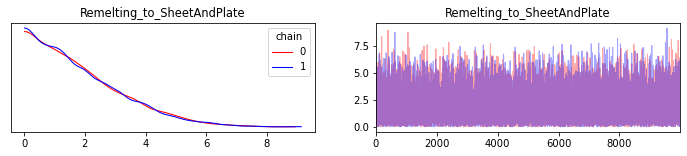

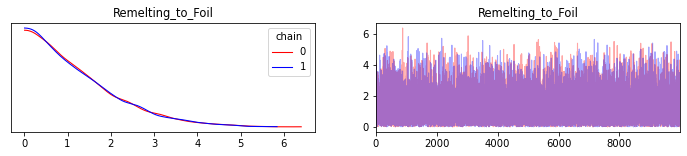

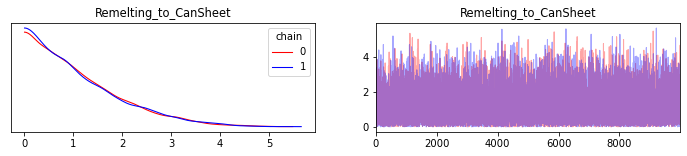

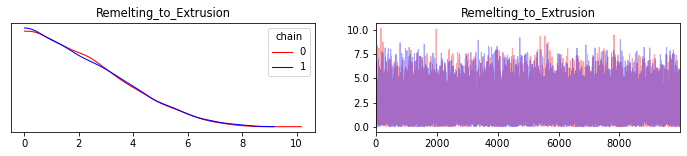

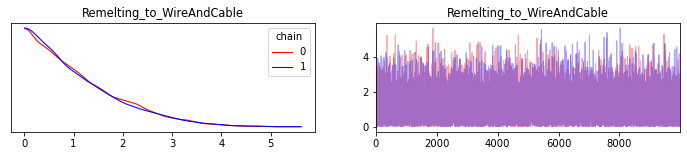

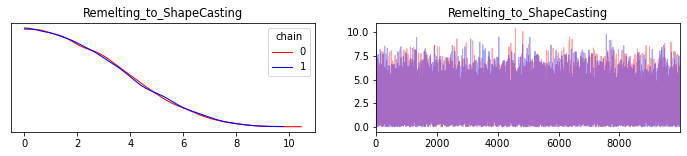

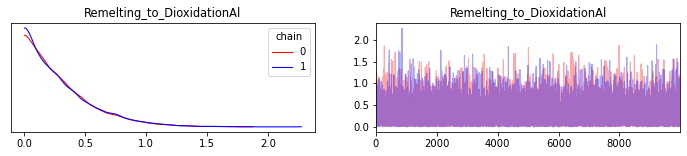

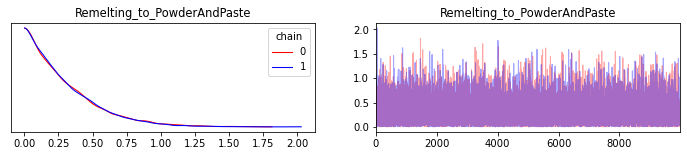

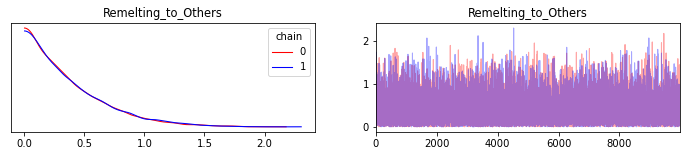

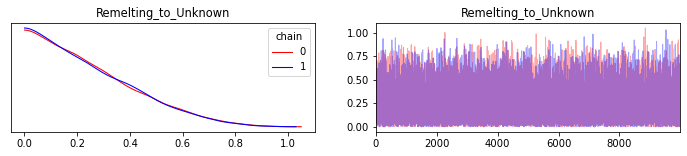

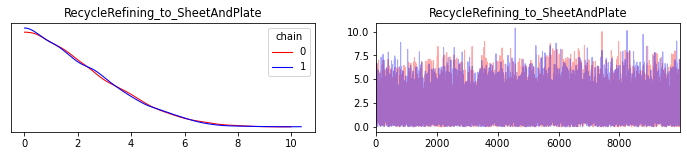

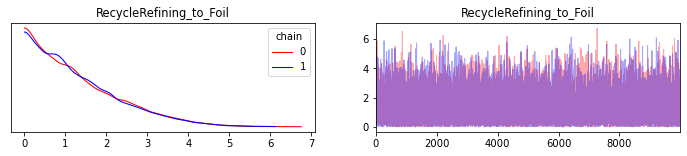

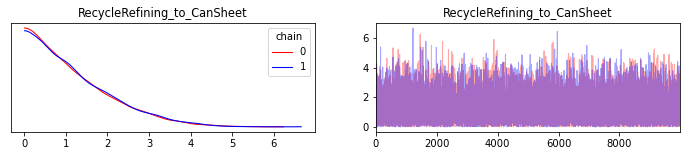

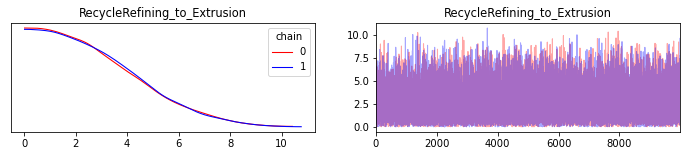

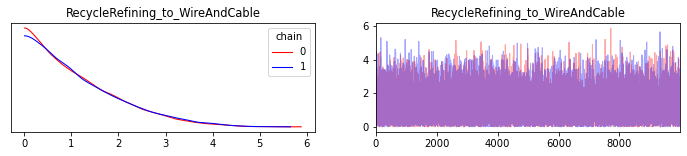

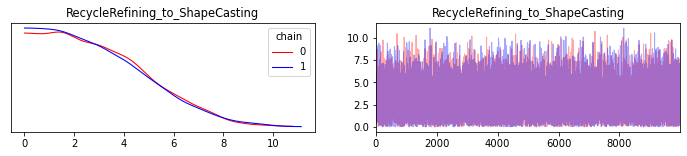

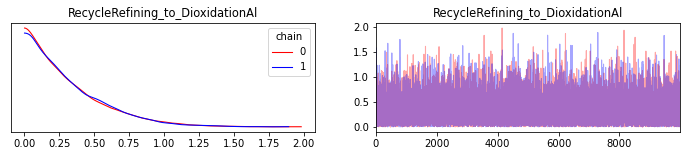

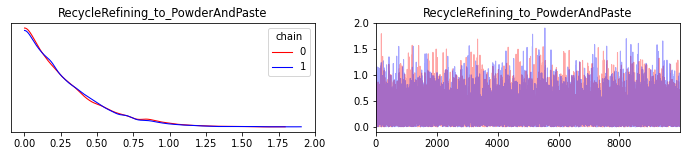

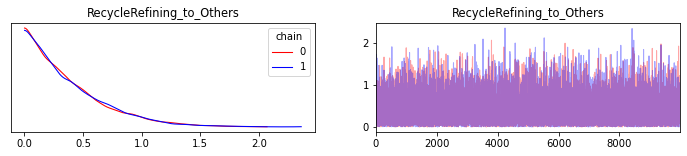

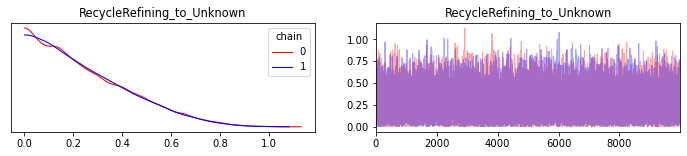

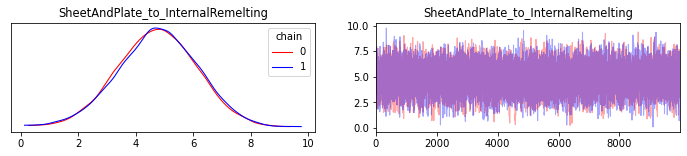

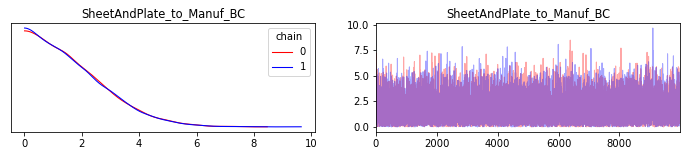

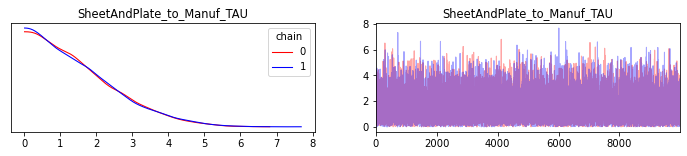

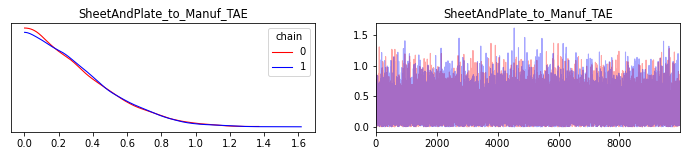

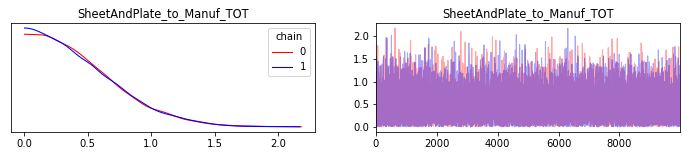

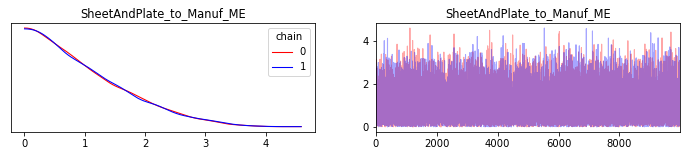

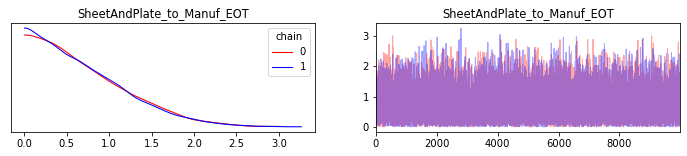

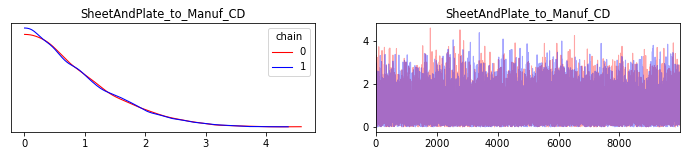

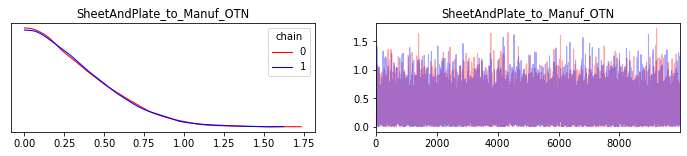

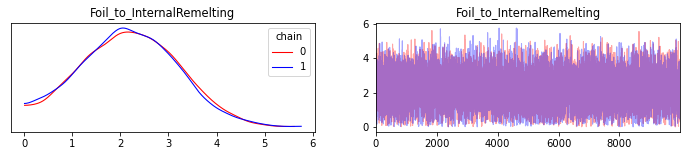

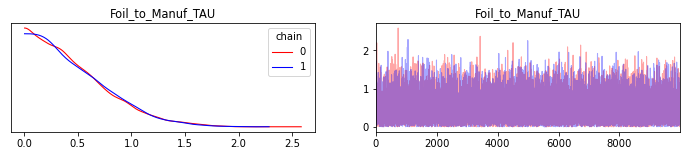

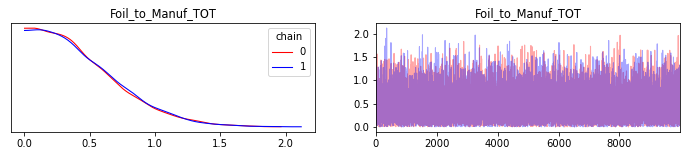

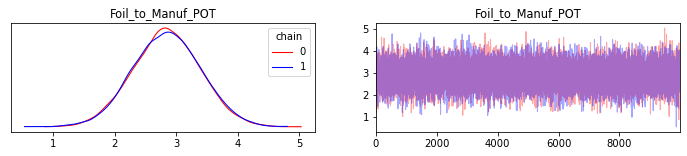

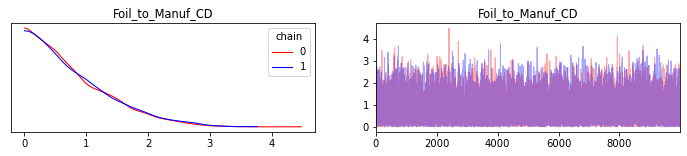

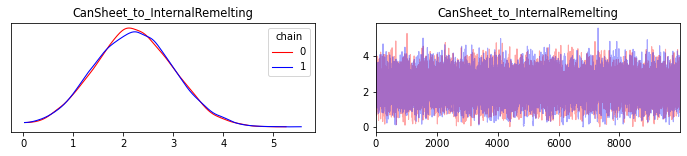

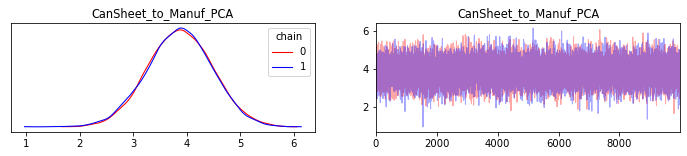

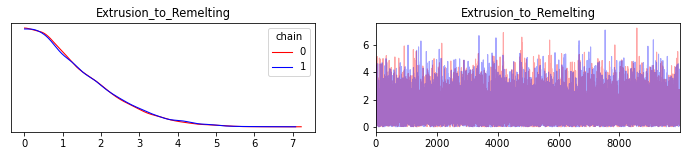

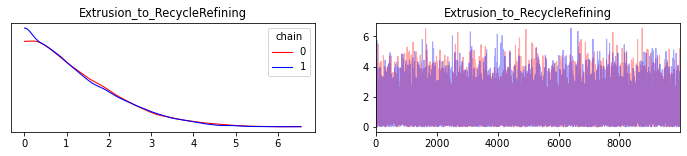

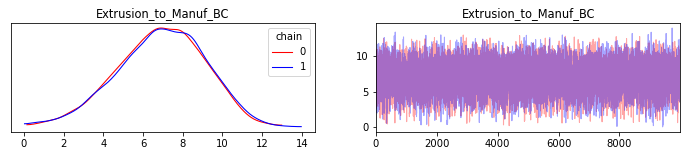

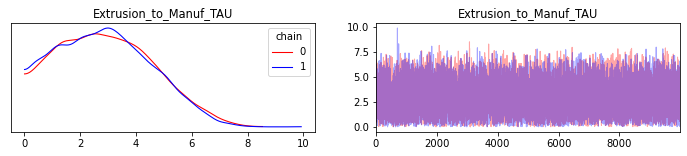

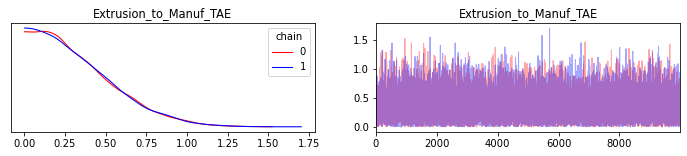

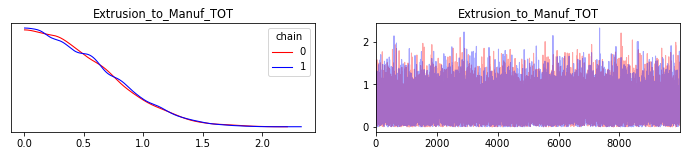

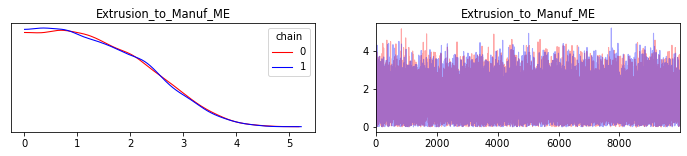

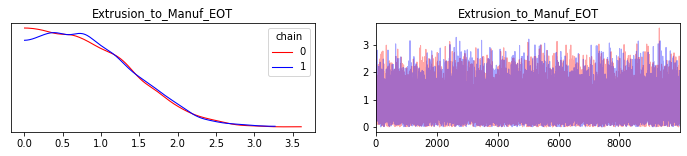

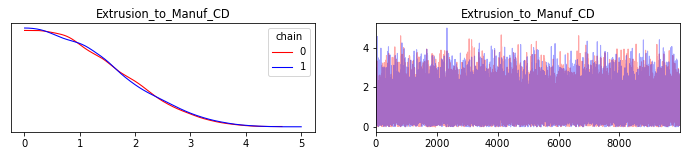

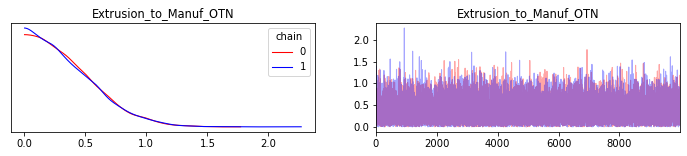

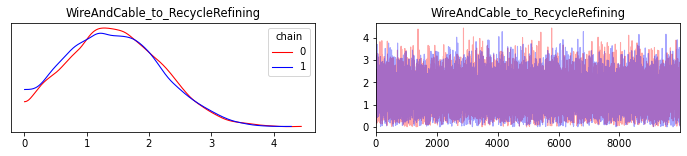

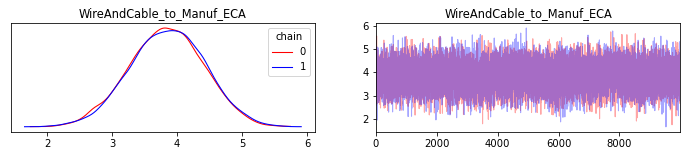

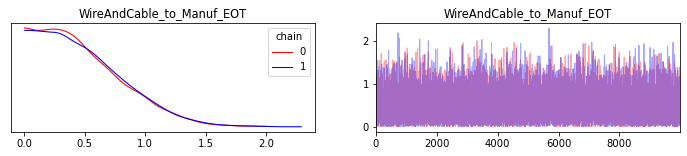

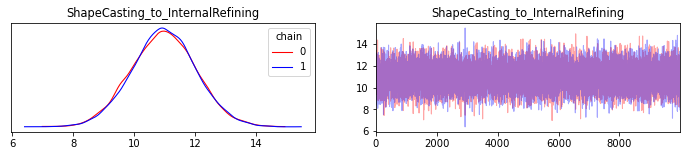

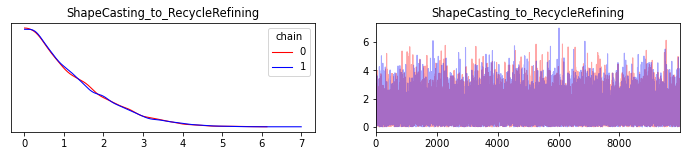

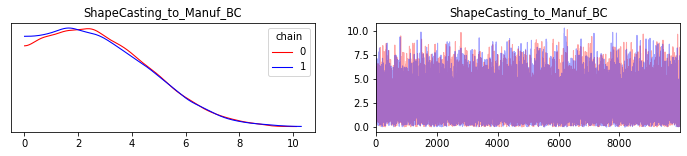

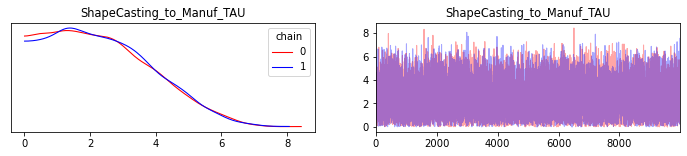

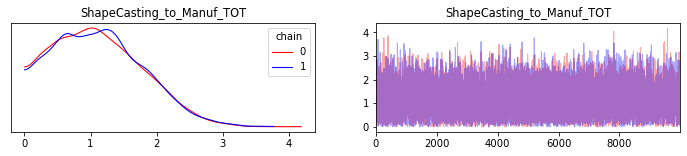

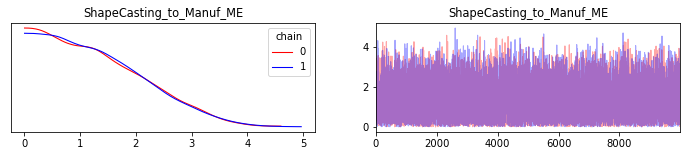

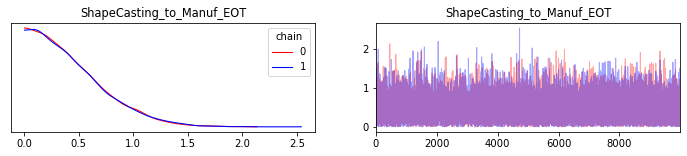

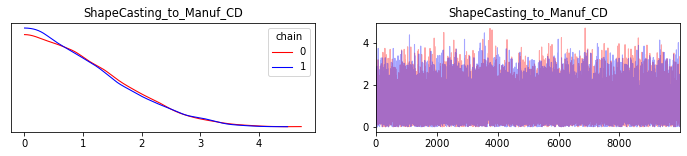

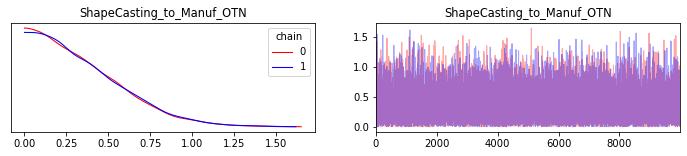

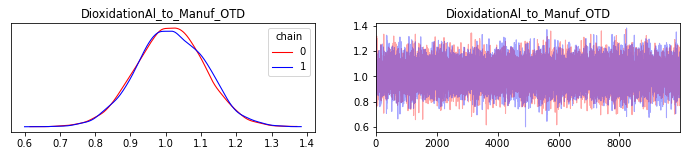

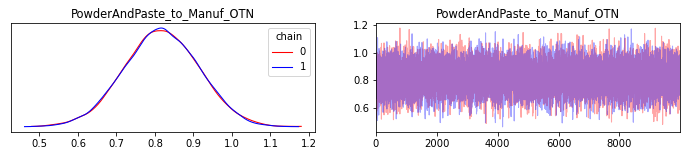

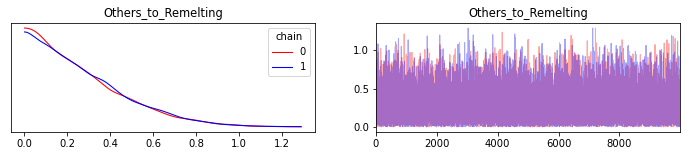

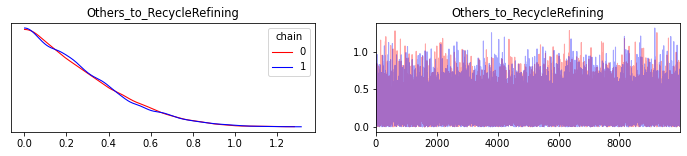

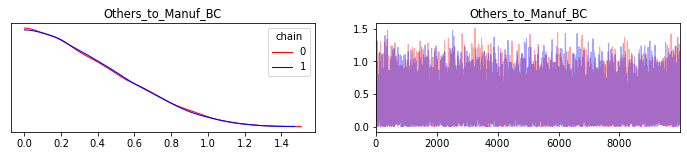

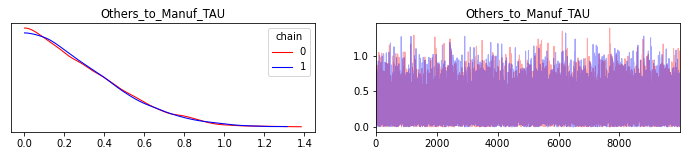

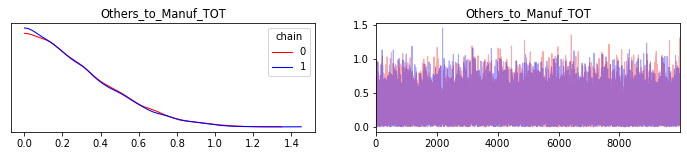

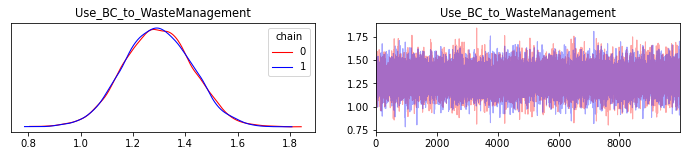

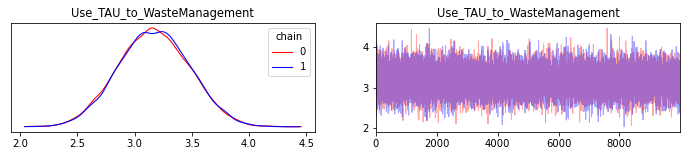

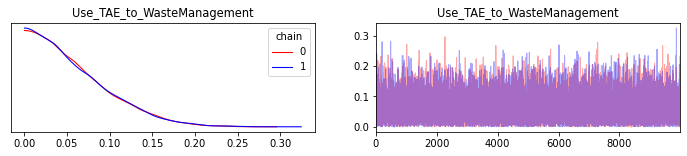

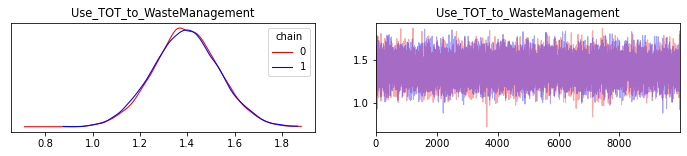

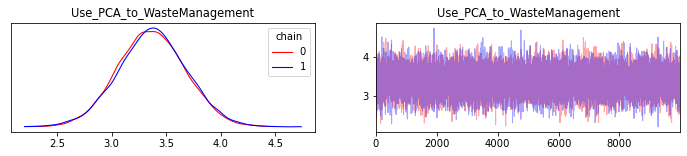

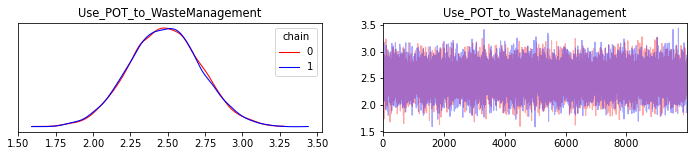

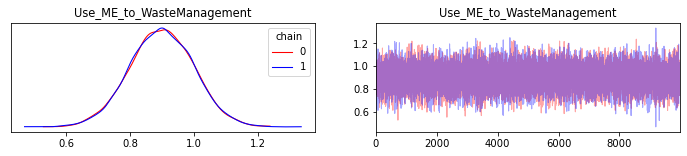

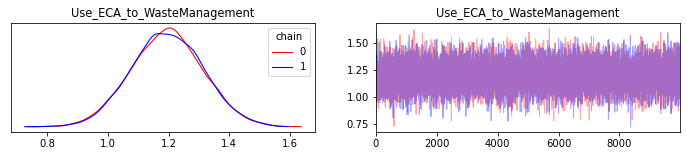

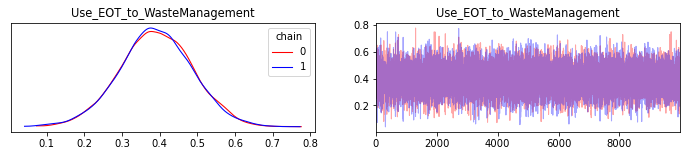

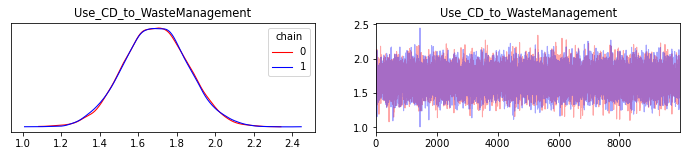

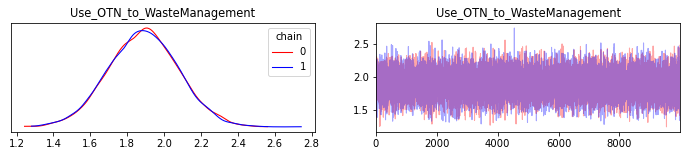

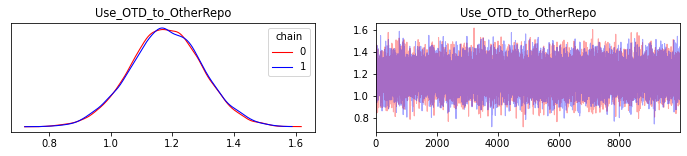

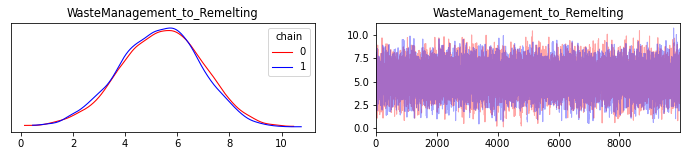

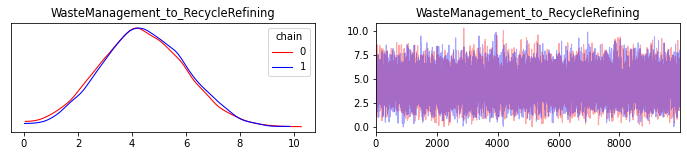

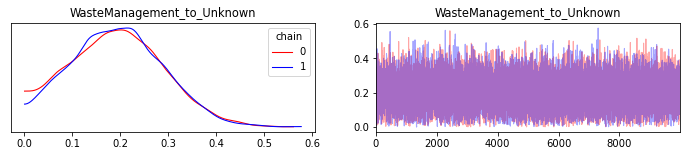

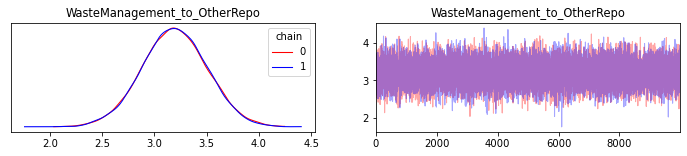

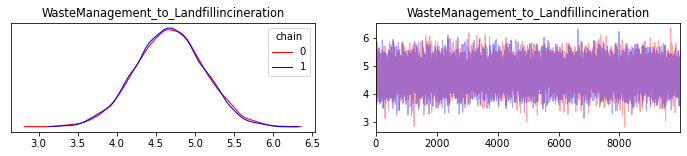

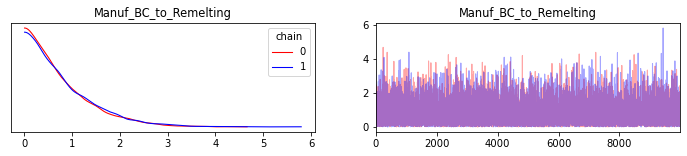

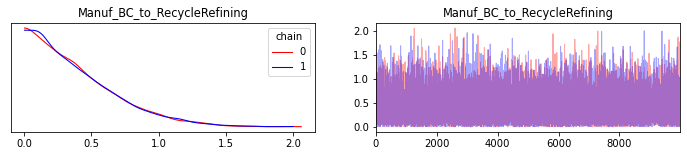

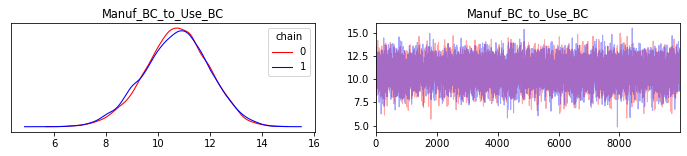

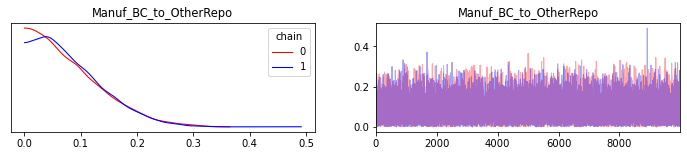

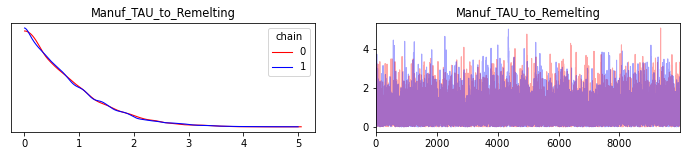

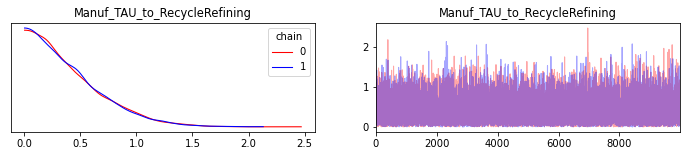

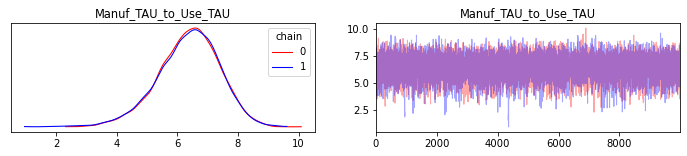

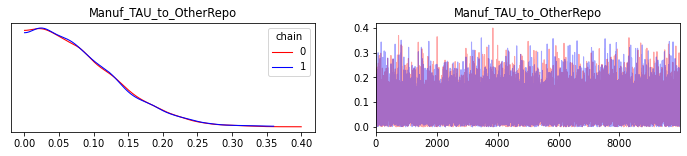

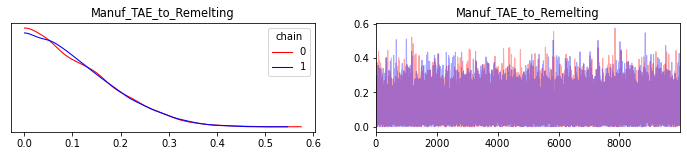

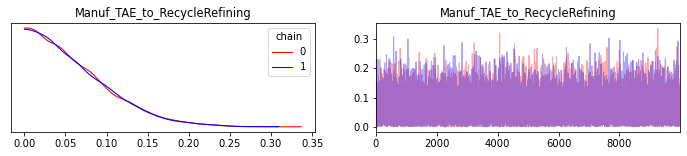

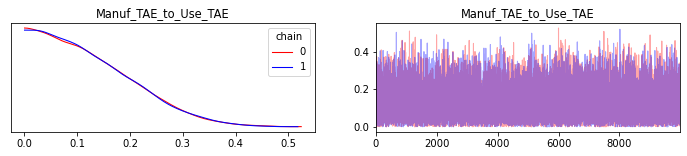

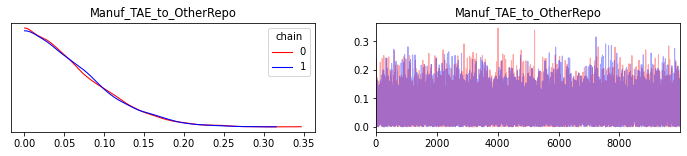

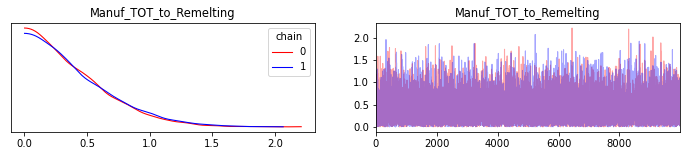

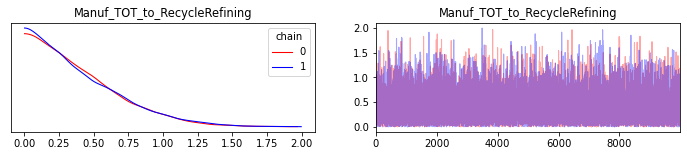

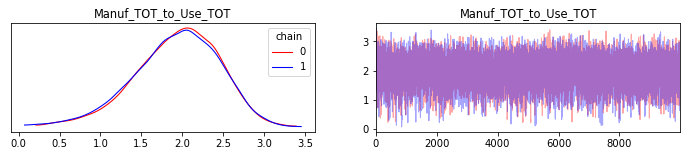

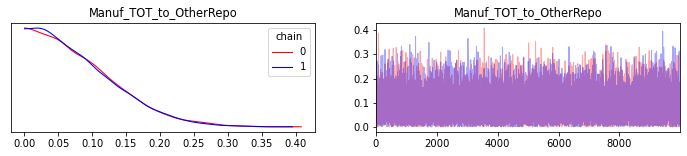

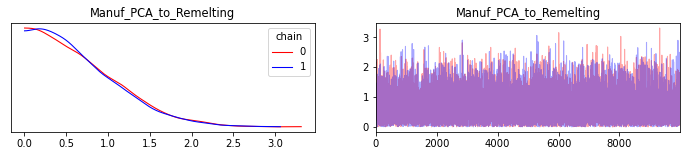

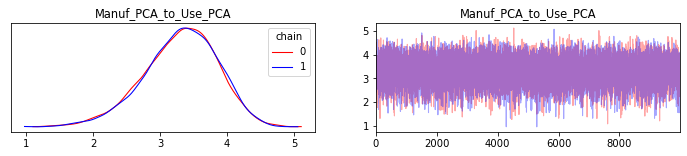

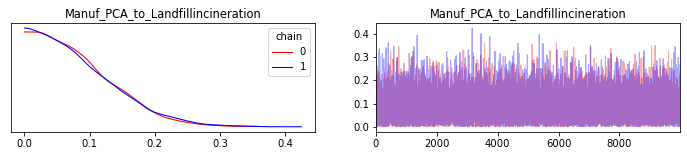

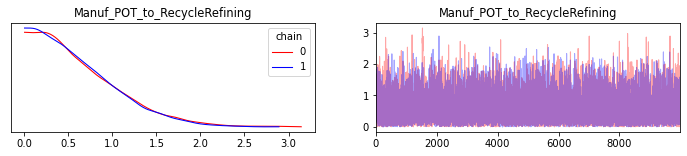

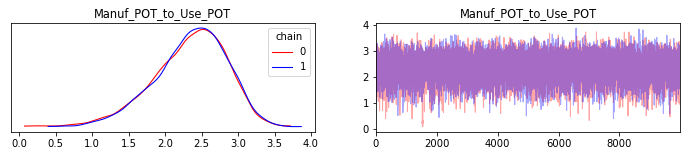

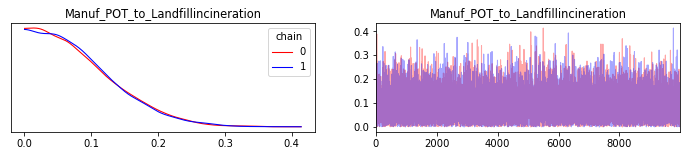

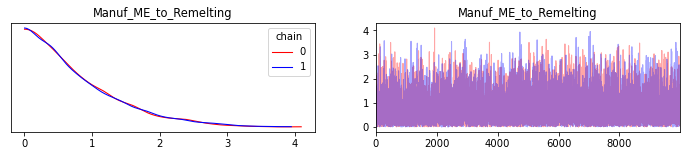

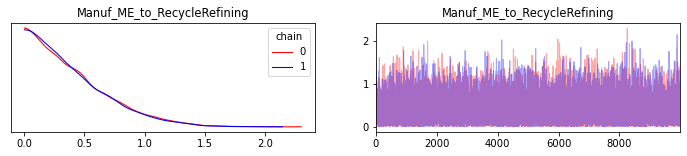

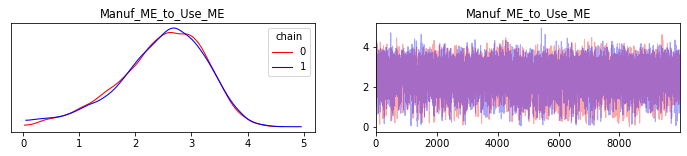

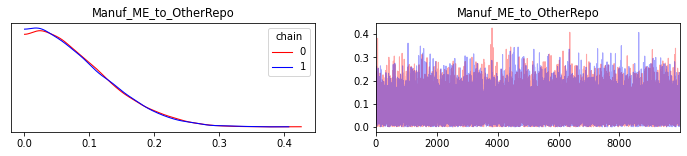

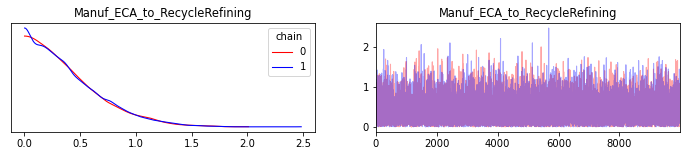

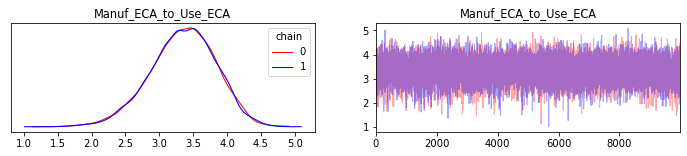

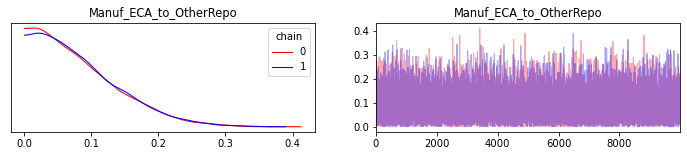

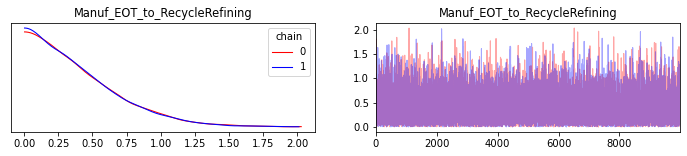

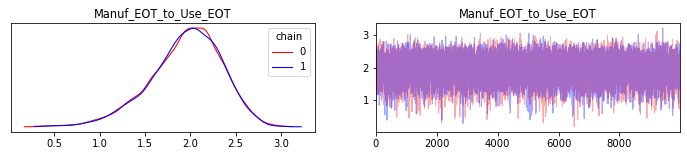

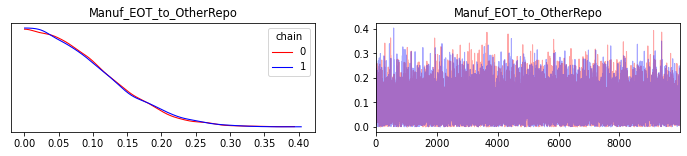

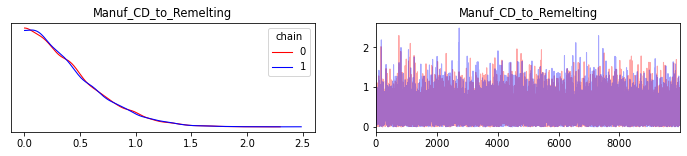

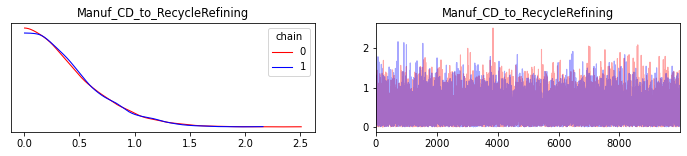

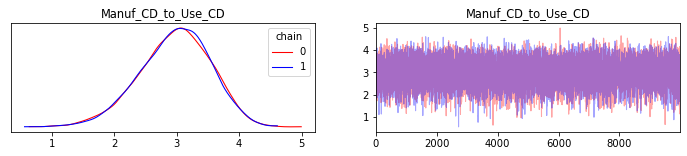

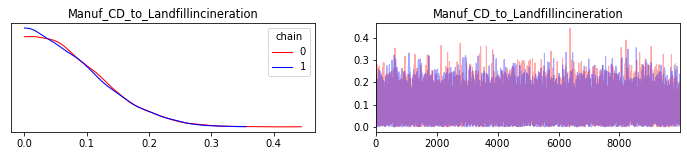

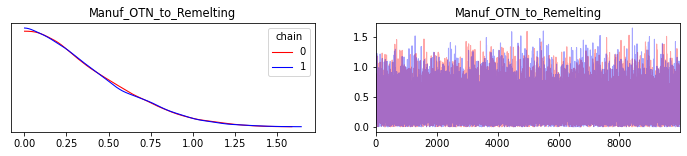

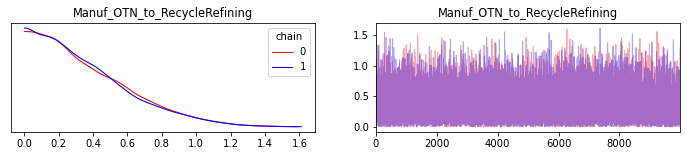

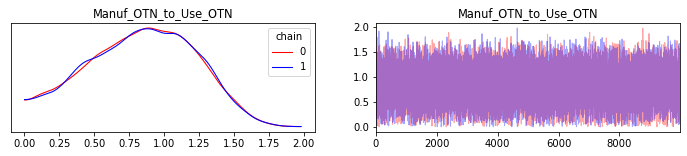

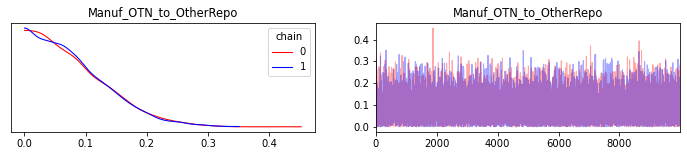

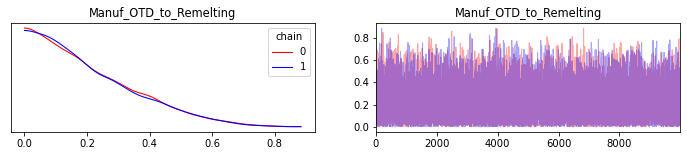

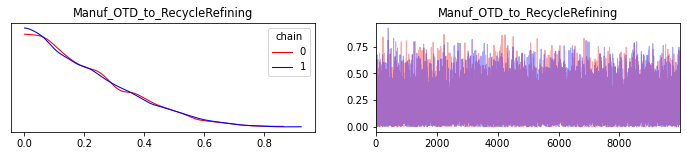

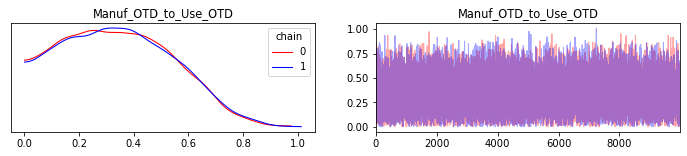

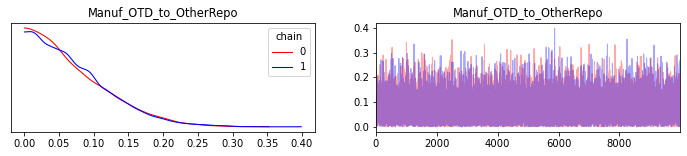

In [6]:
#generate traceplots for the flow variables

az.rcParams["plot.max_subplots"] = 400 #this increases the maximum plots displayed, default is 40.
#There are around 200 posterior flow plots so without this you only plot the first 40. 

plt.tight_layout()


for i in range(0, len(availablechildflows)):
    relevantrow=np.where(allflownumbersmatrix[:, 0] == str(availablechildflows[i]))
    relevantrow=relevantrow[0][0]
    flownumberfrom=allflownumbersmatrix[relevantrow, 1]
    flownumberto=allflownumbersmatrix[relevantrow, 2]
    
    labeller = azl.MapLabeller(var_name_map={"flows": processnamesdict[str(flownumberfrom)]+"_to_"+processnamesdict[str(flownumberto)]})
    posteriorflowtraceplots=az.plot_trace(trace, var_names="flows",compact=True,show=True,backend="matplotlib", coords={'flows_dim_0': [i]},labeller=labeller,legend=True,chain_prop={"color": ['r', 'b']})

    posteriorflowtraceplots[0,0].get_figure().savefig("outputgraphstrace"+filelabeler(useratiodata)+"/"+"Flowtrace"+processnamesdict[str(flownumberfrom)]+"_to_"+processnamesdict[str(flownumberto)]+filelabeler(useratiodata)+".pdf")

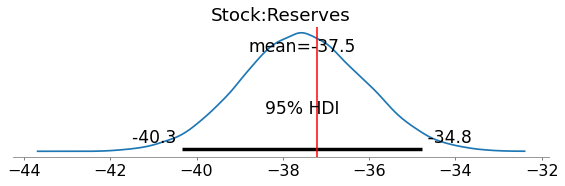

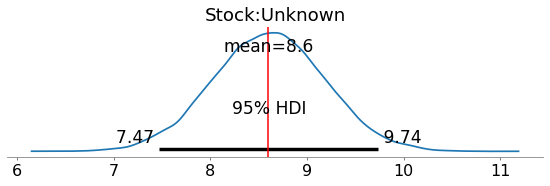

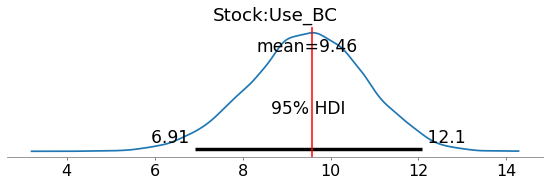

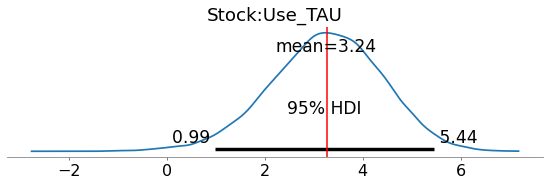

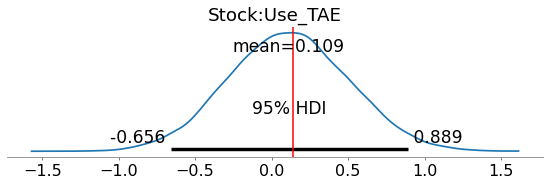

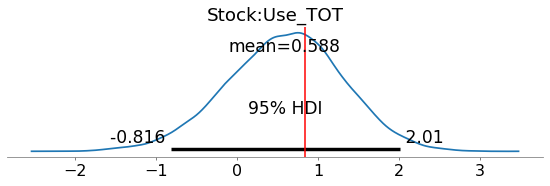

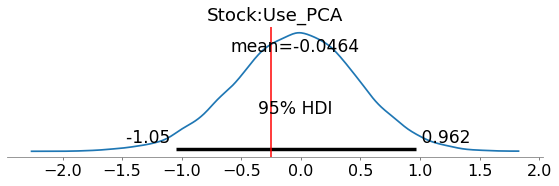

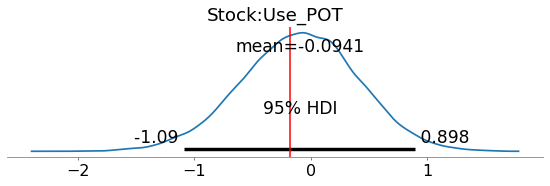

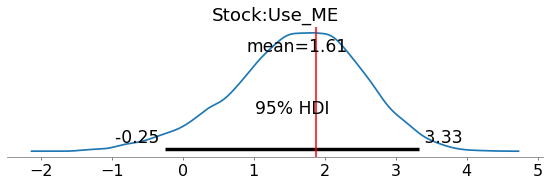

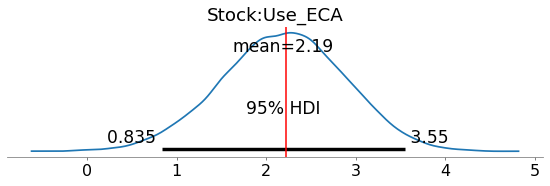

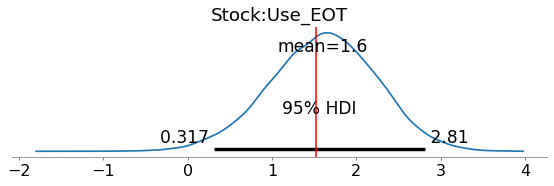

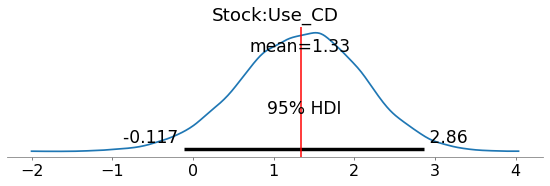

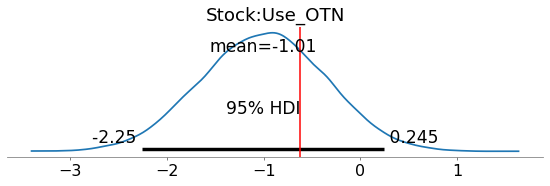

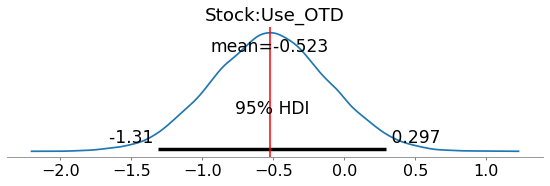

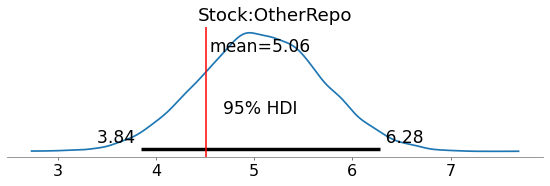

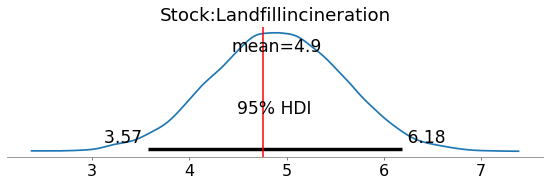

In [7]:
#plot marginal posterior distribution for change in stock variables

labels=[processnamesdict[str(x)] for x in availablechildstocks]

    
for i in range(0,len(labels)):
    posteriorstockplots=az.plot_posterior(trace, var_names="stocks",show=False,backend="matplotlib",round_to=3, hdi_prob=0.95,  coords={'stocks_dim_0': [i]}, textsize=16,figsize=[9.6, 2.4])
    posteriorstockplots.title.set_text("Stock"+":"+labels[i]) 
    plt.axvline(x=truevalues[availablechildstocks][i], color="red")
    posteriorstockplots.get_figure().savefig("outputgraphs"+filelabeler(useratiodata)+"/"+"Stock"+"_"+labels[i]+filelabeler(useratiodata)+".pdf")

C:\Users\Public\anaconda1\envs\pymc_env\lib\site-packages\arviz\plots\backends\matplotlib\__init__.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = subplots(rows, cols, **backend_kwargs)


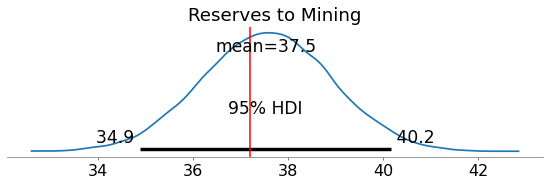

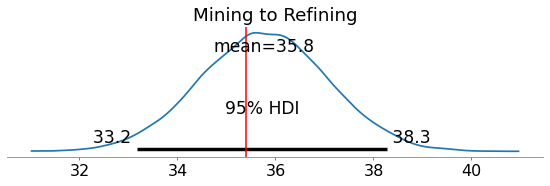

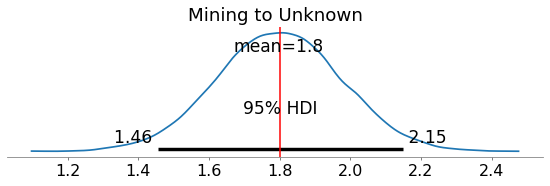

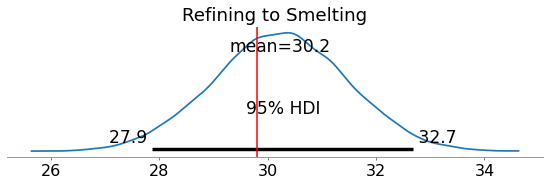

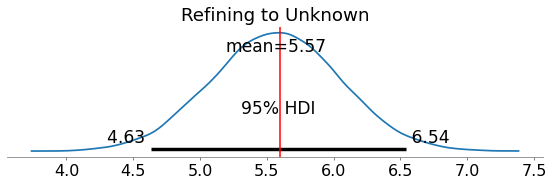

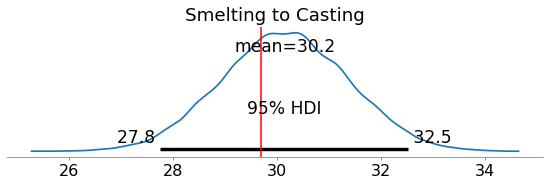

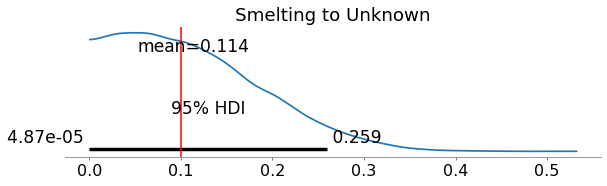

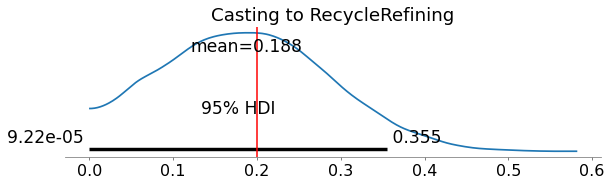

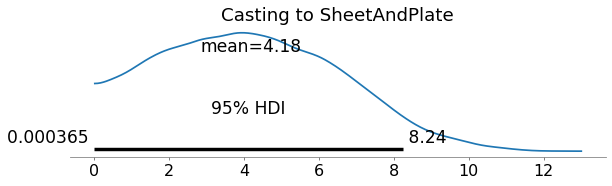

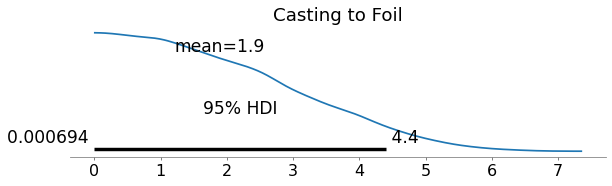

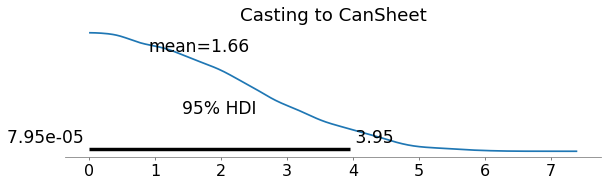

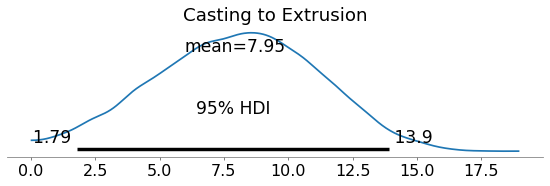

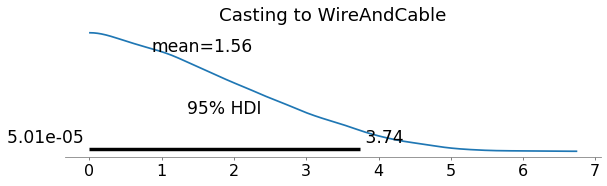

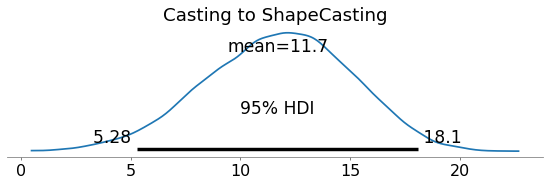

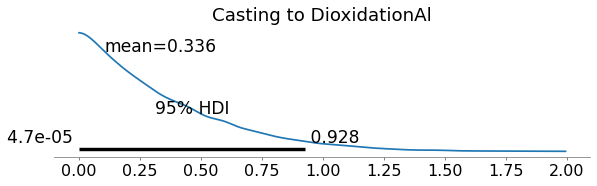

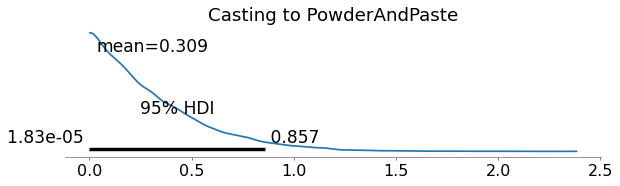

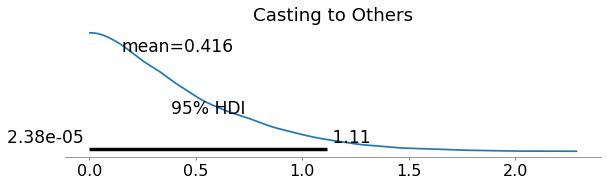

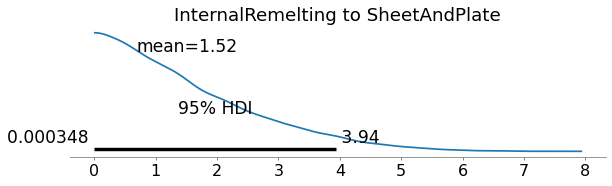

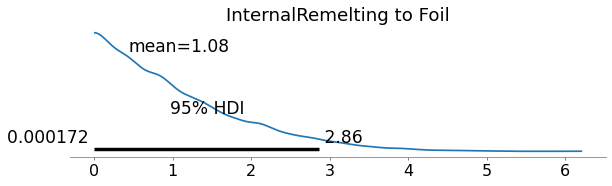

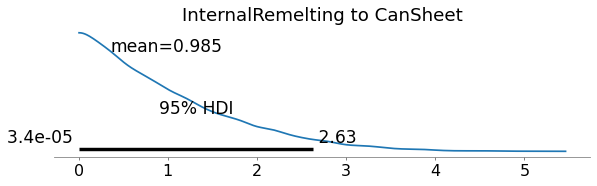

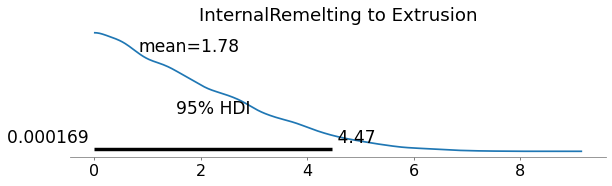

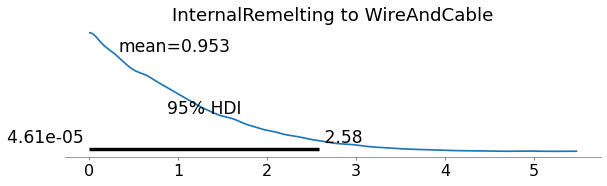

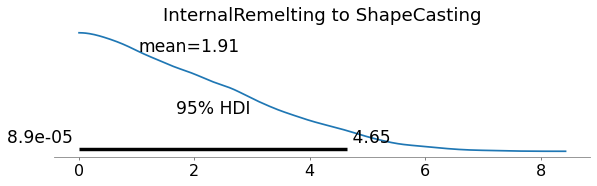

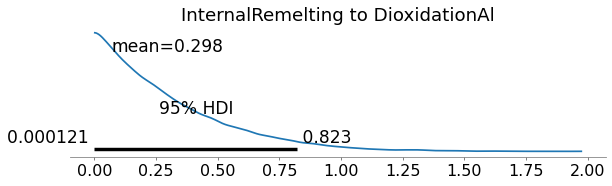

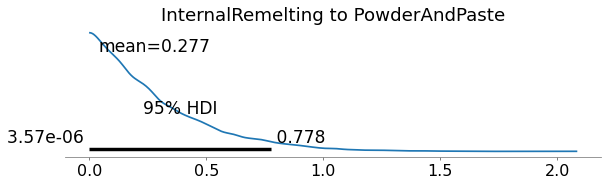

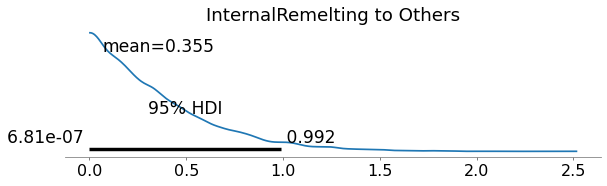

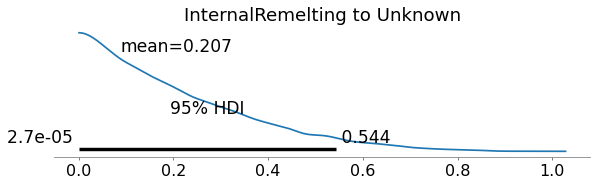

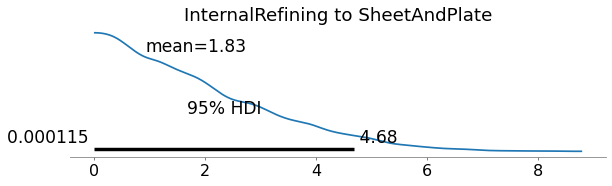

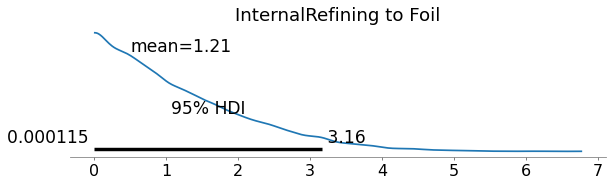

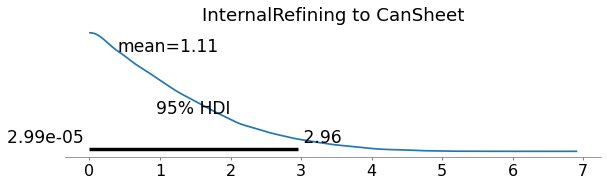

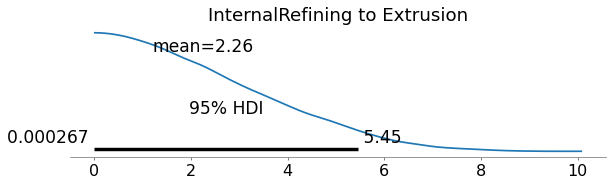

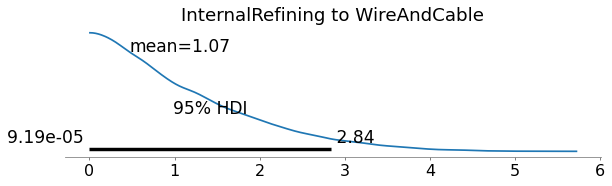

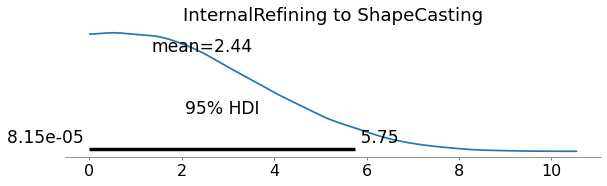

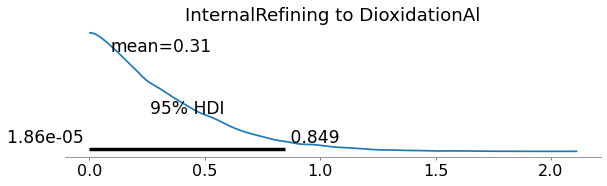

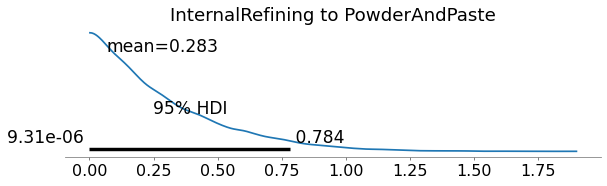

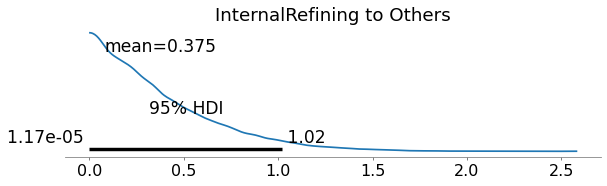

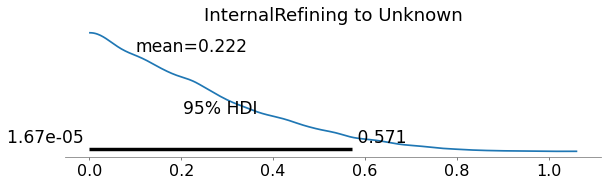

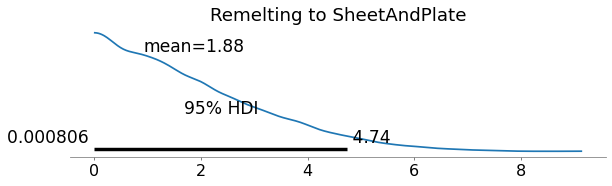

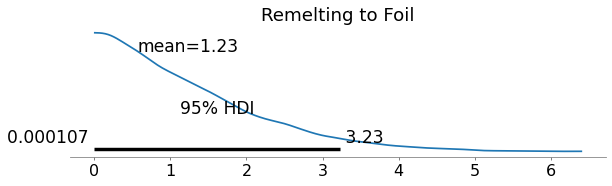

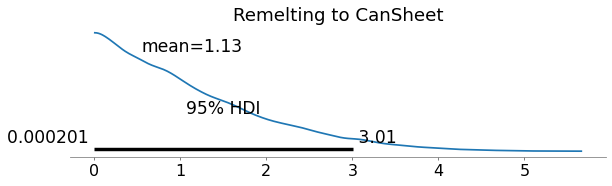

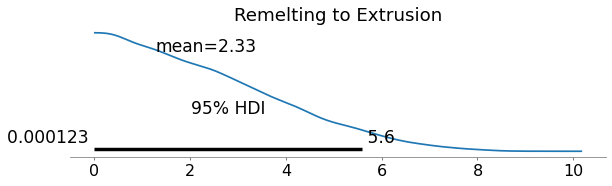

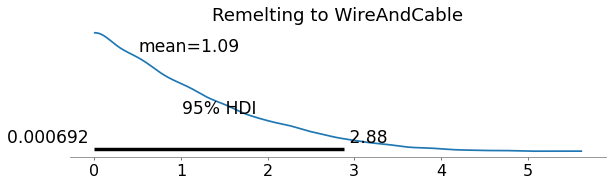

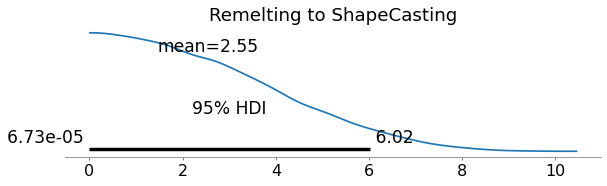

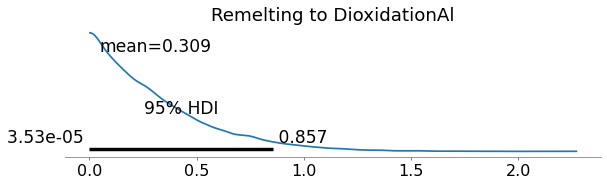

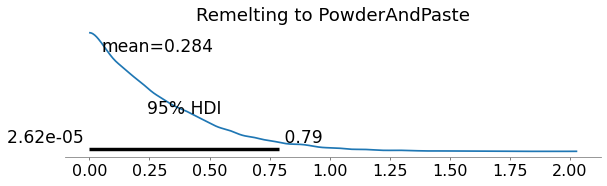

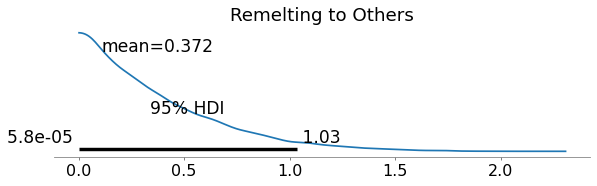

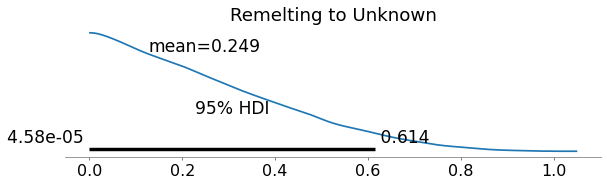

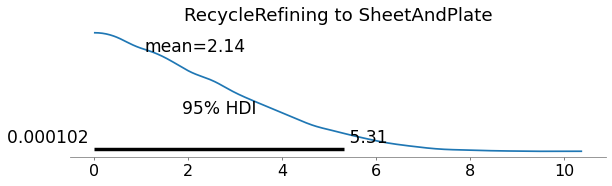

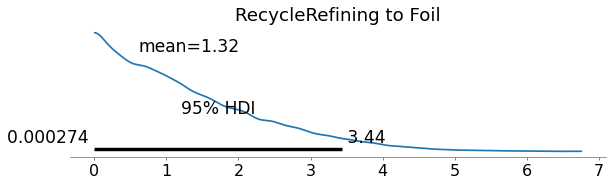

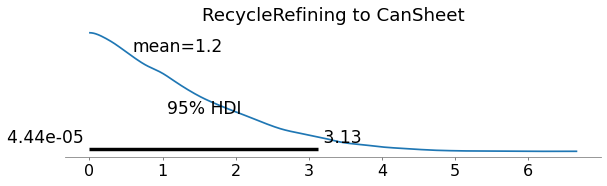

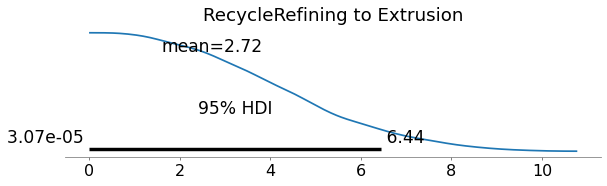

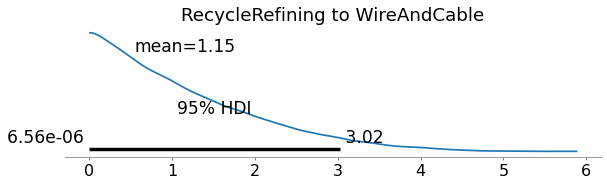

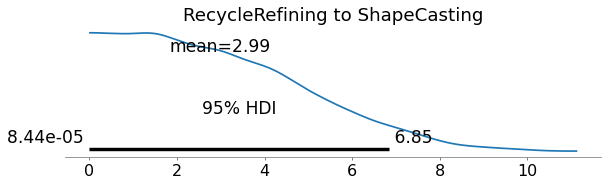

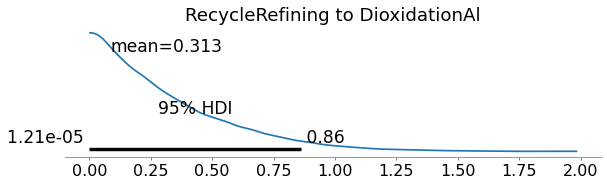

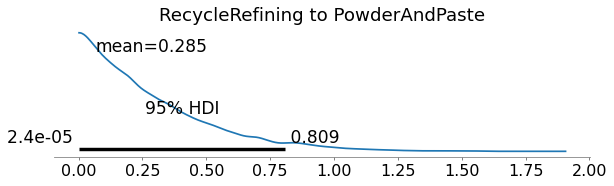

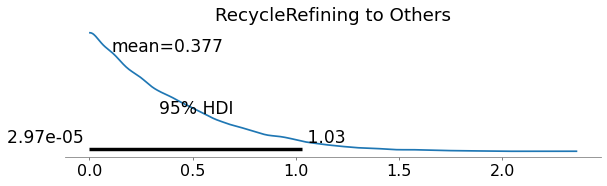

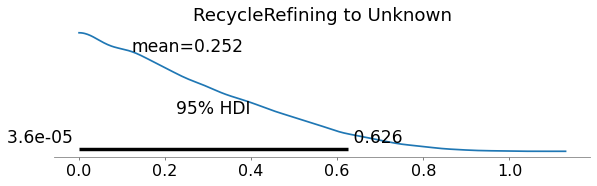

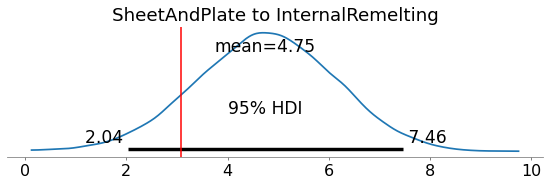

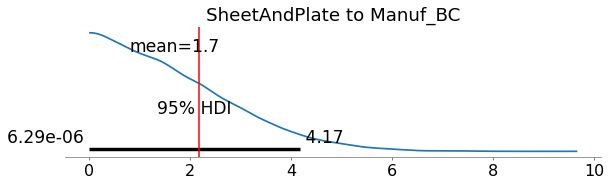

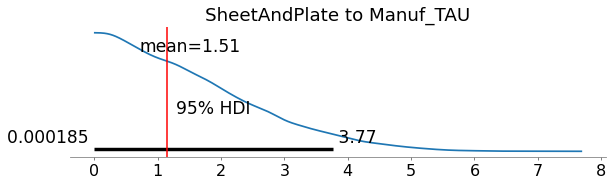

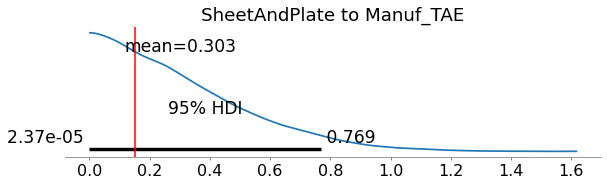

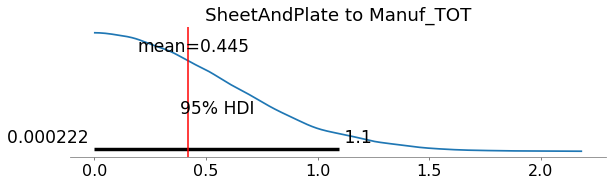

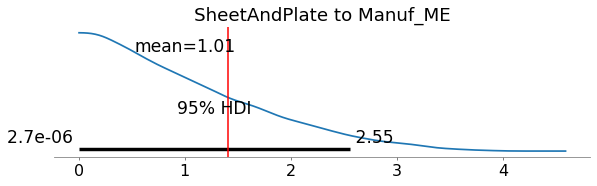

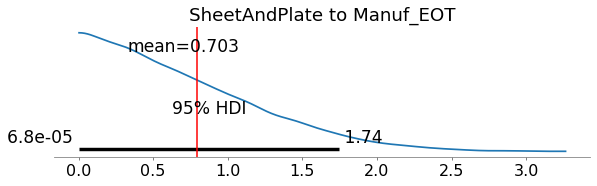

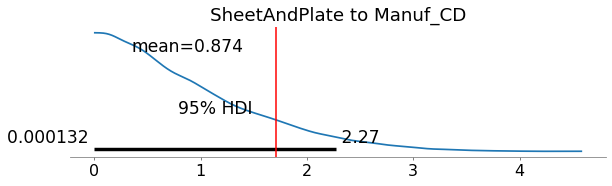

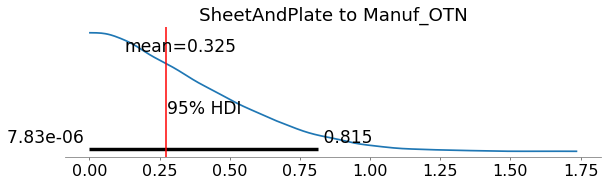

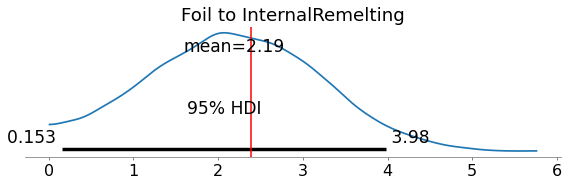

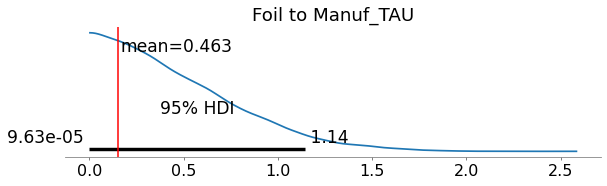

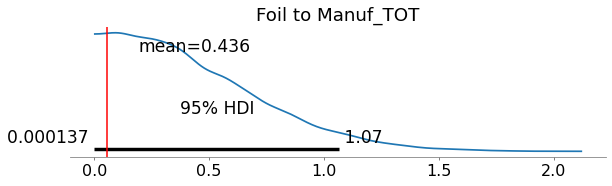

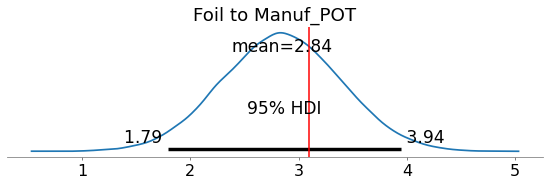

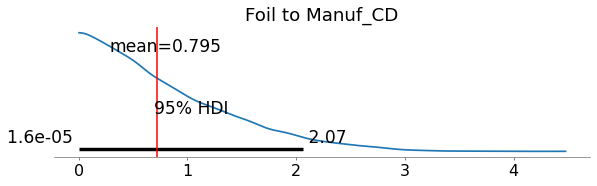

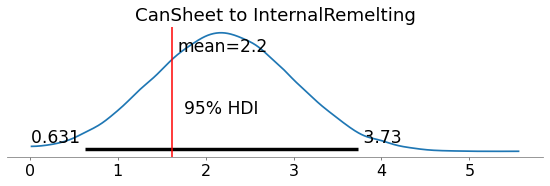

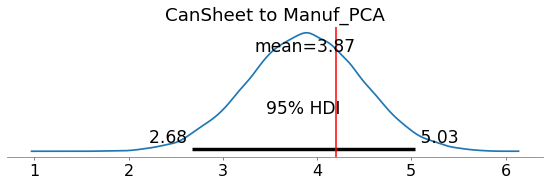

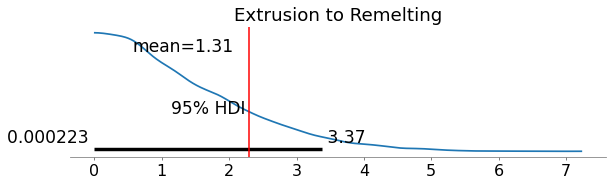

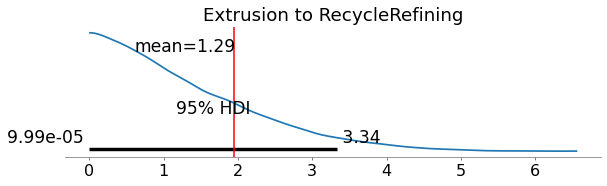

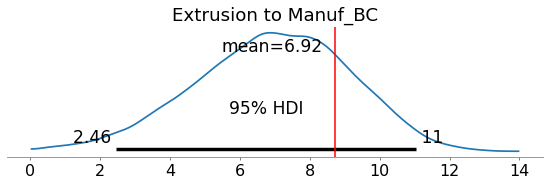

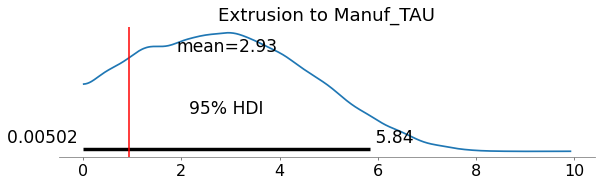

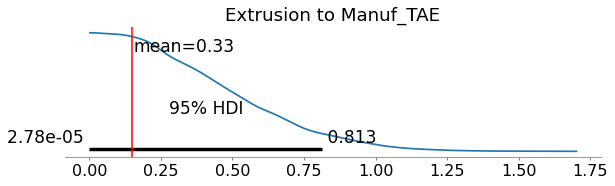

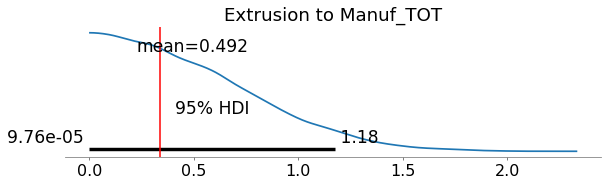

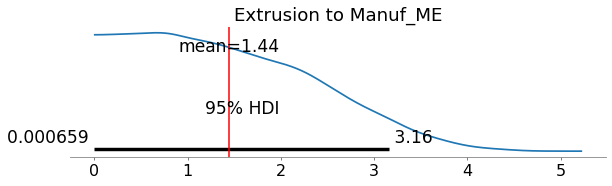

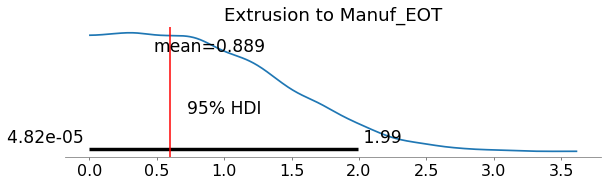

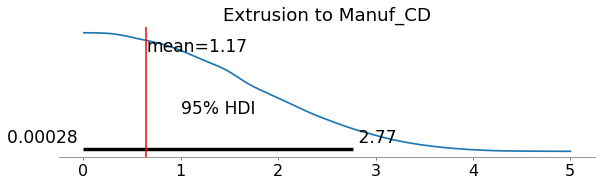

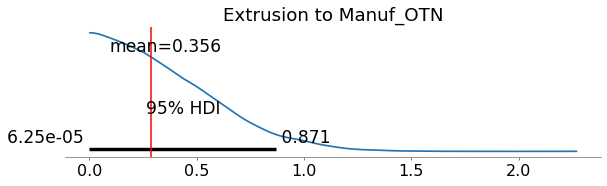

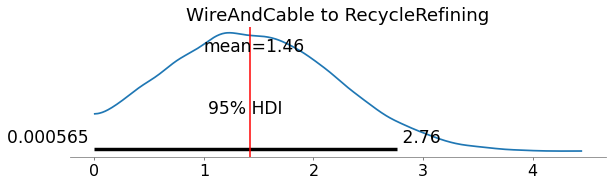

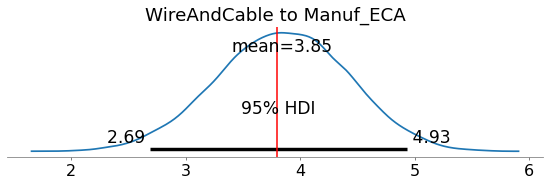

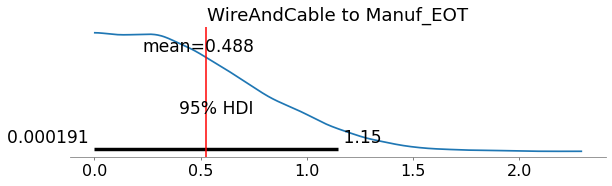

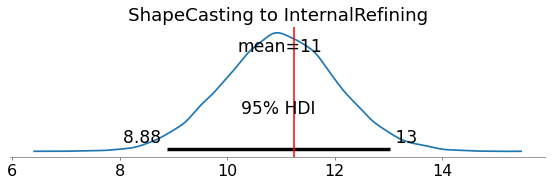

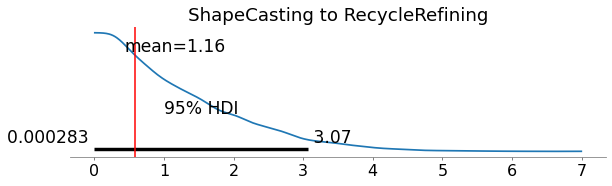

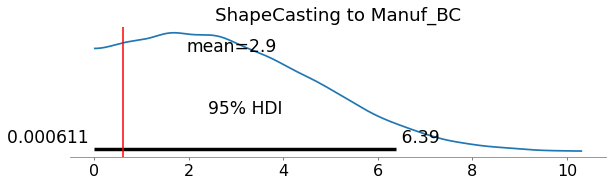

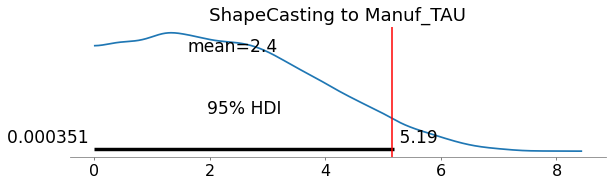

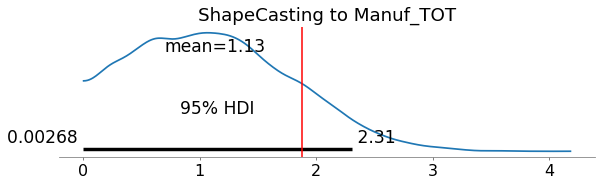

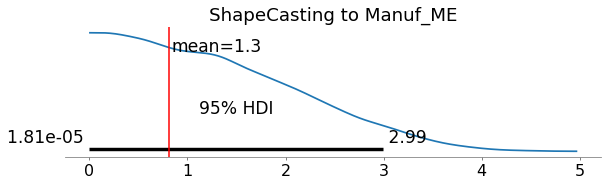

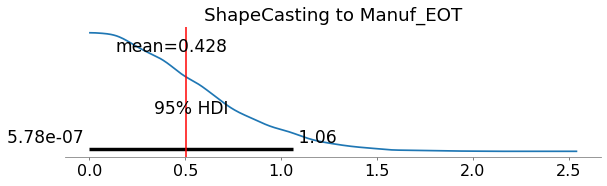

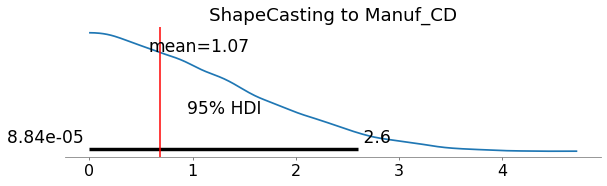

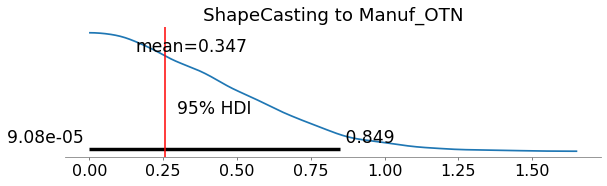

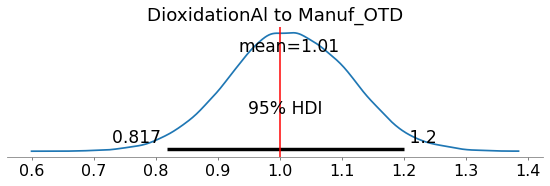

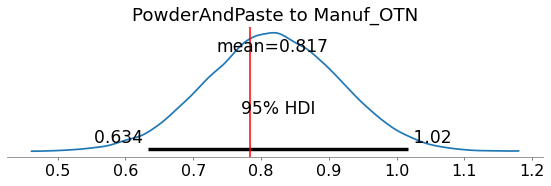

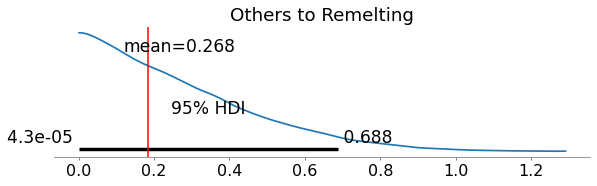

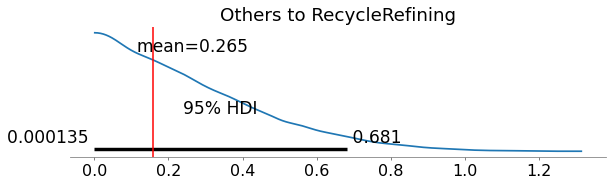

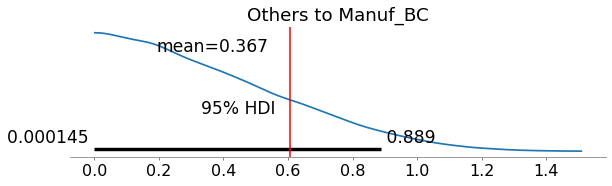

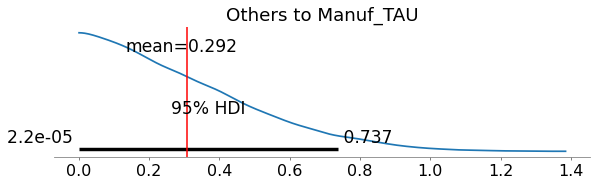

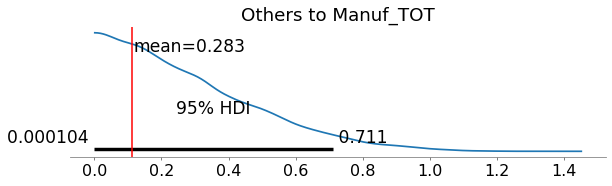

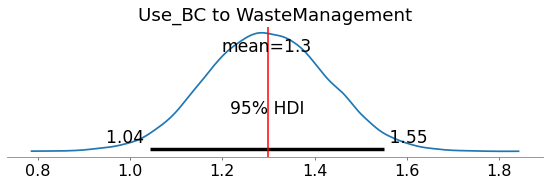

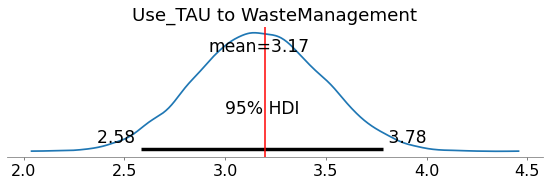

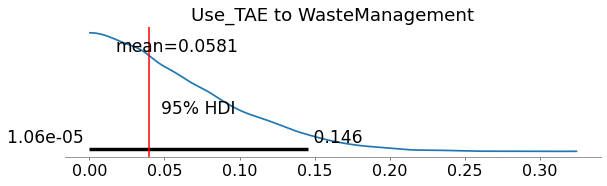

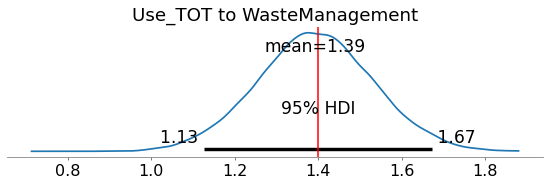

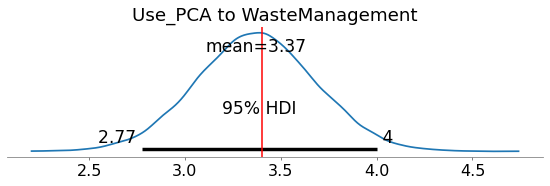

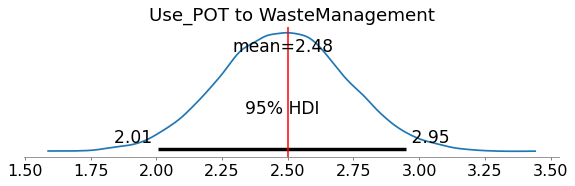

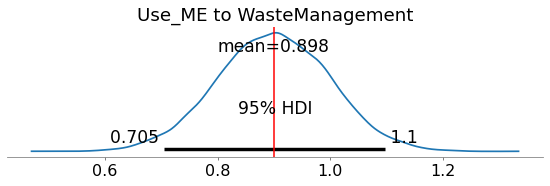

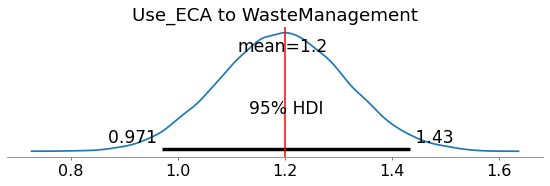

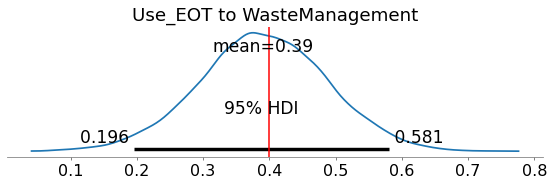

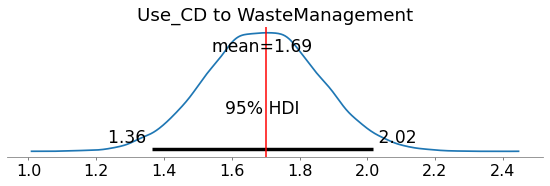

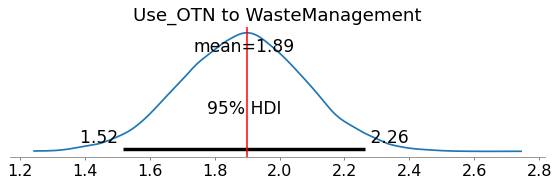

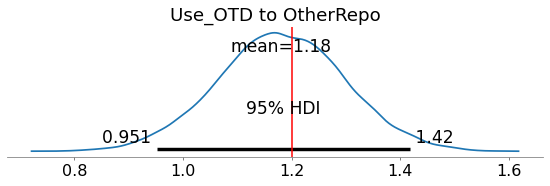

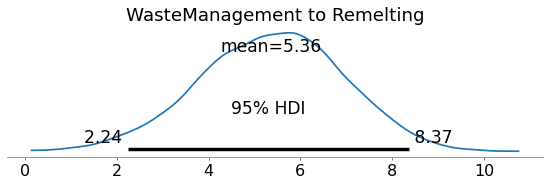

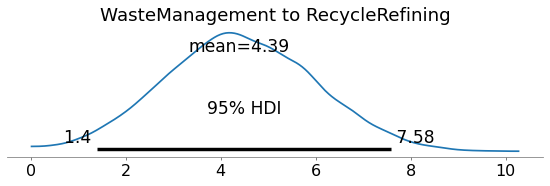

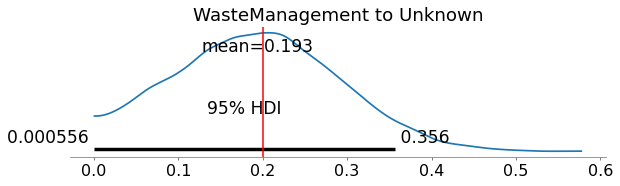

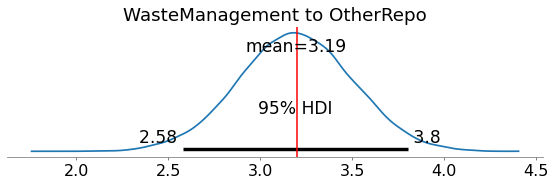

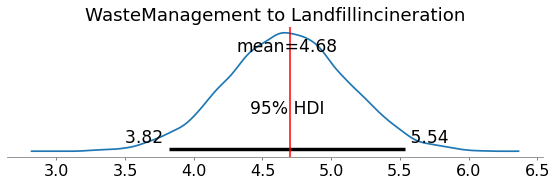

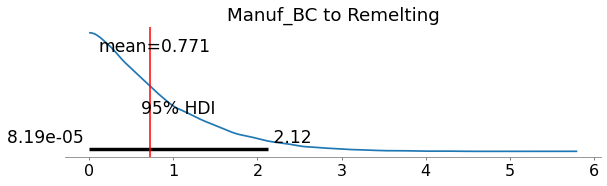

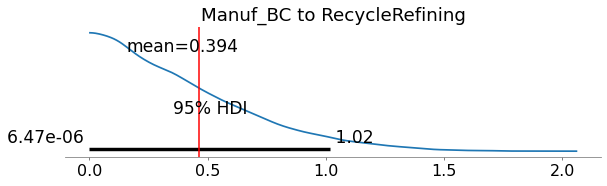

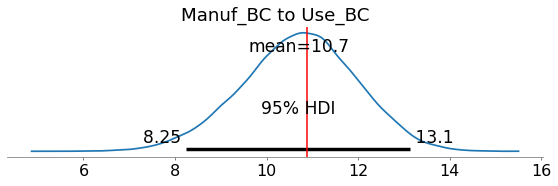

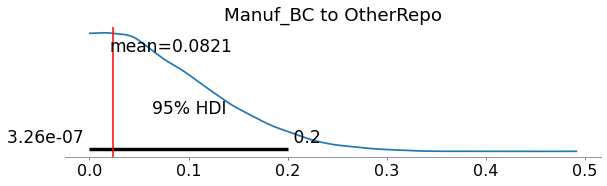

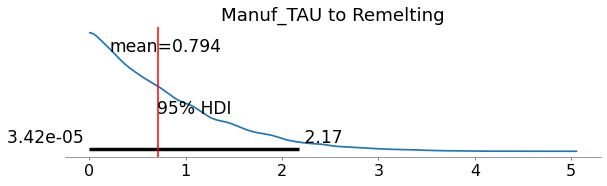

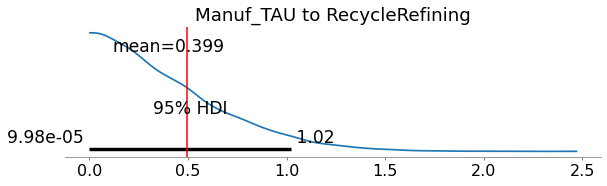

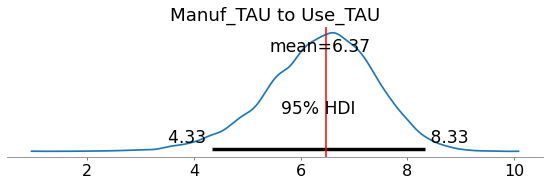

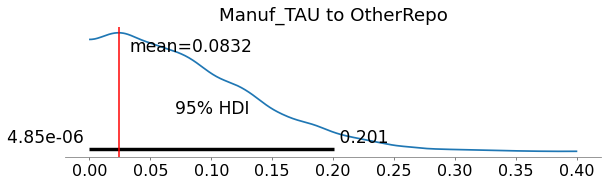

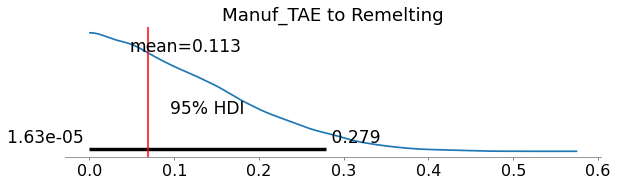

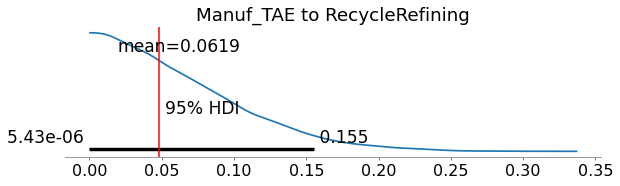

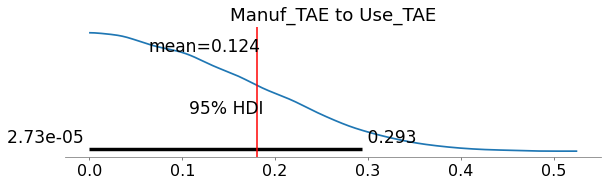

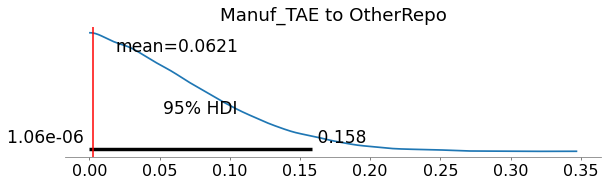

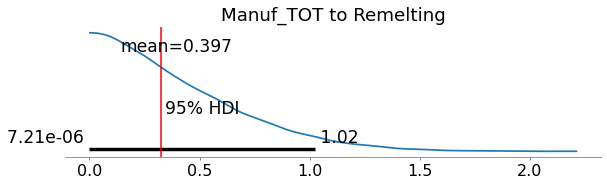

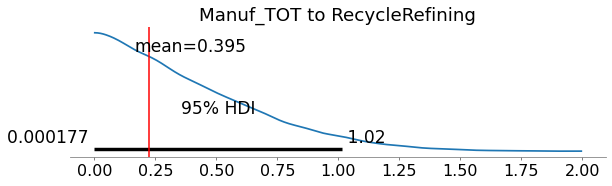

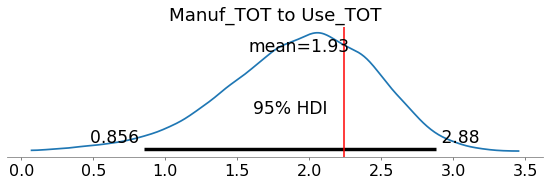

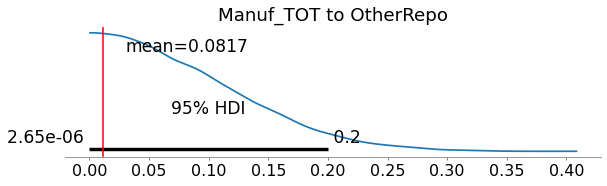

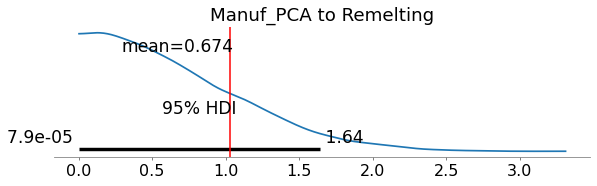

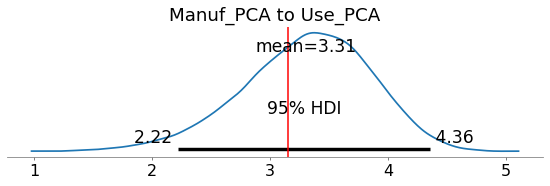

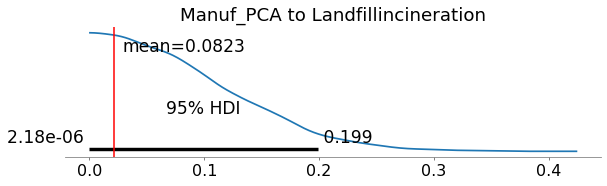

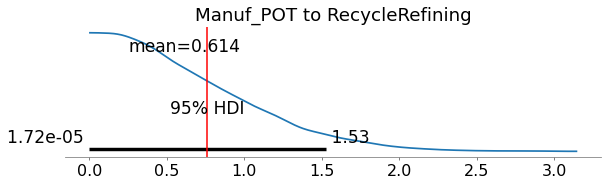

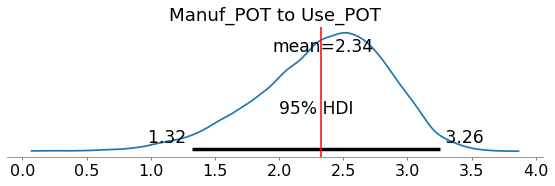

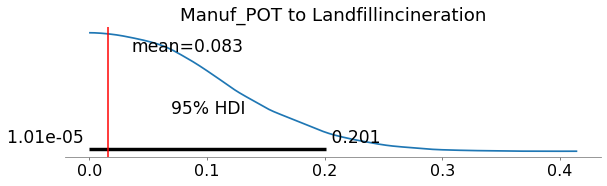

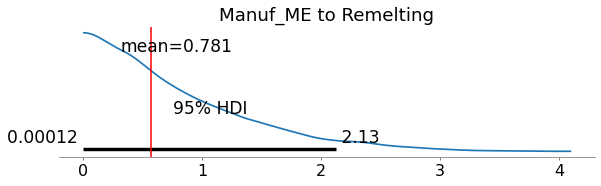

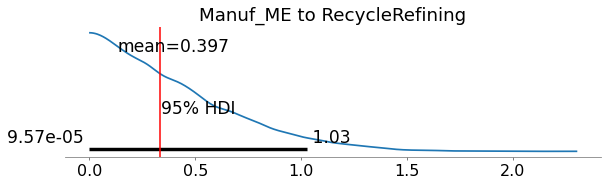

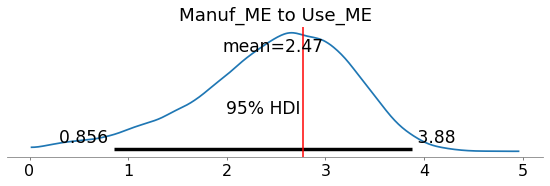

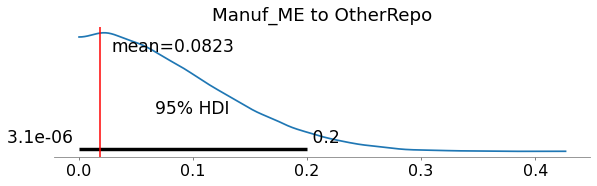

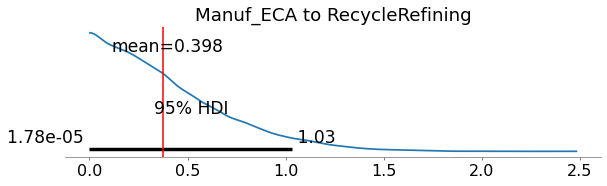

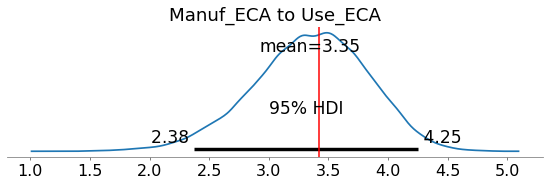

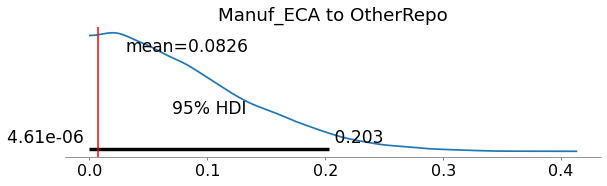

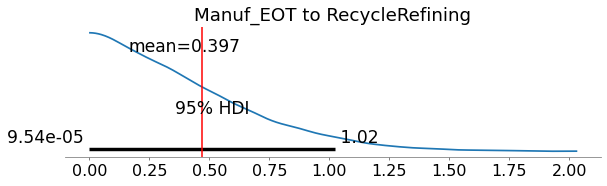

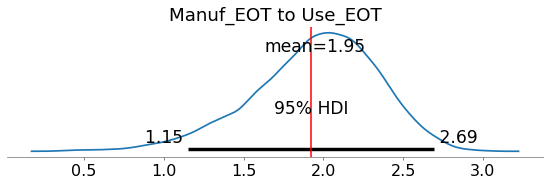

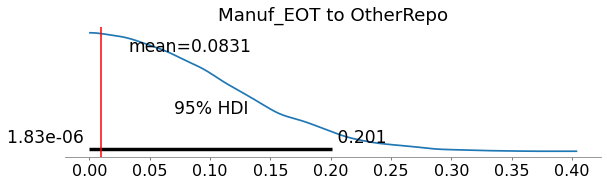

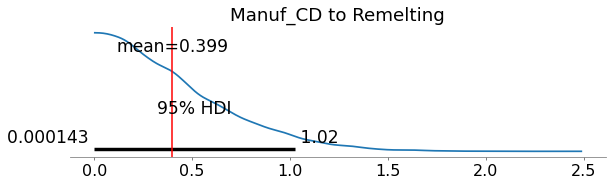

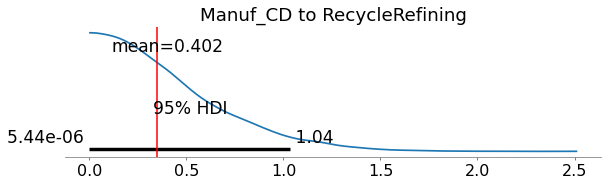

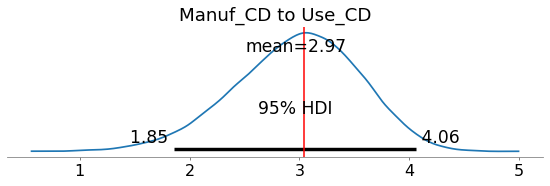

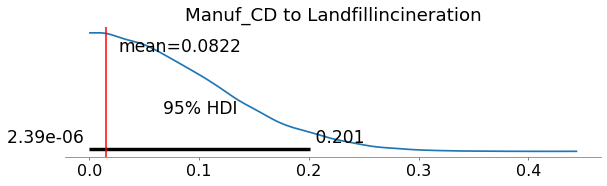

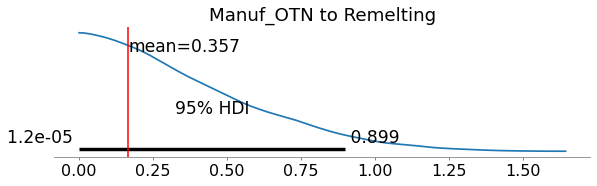

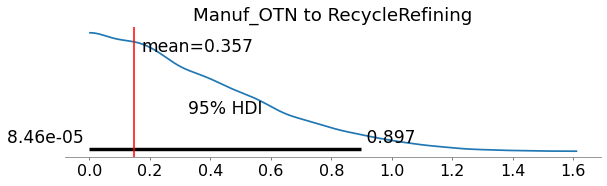

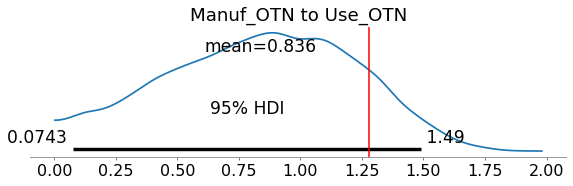

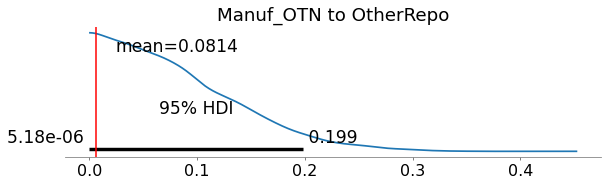

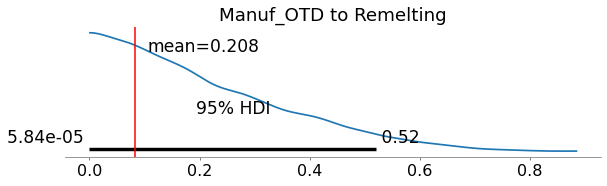

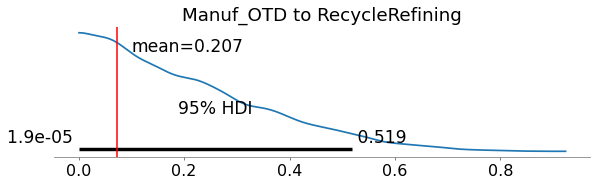

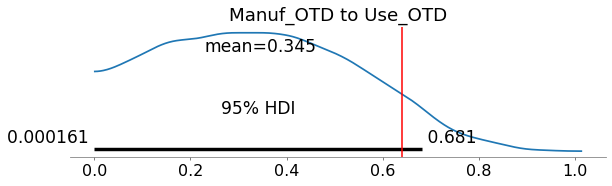

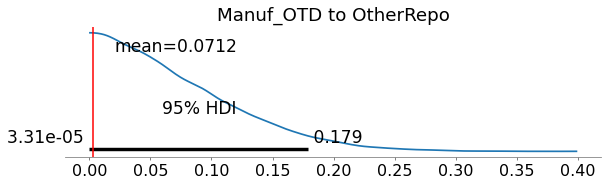

In [8]:
#plot marginal posterior distribution for flow variables

az.rcParams["plot.max_subplots"] = 400 #this increases the maximum plots displayed, default is 40.
#There are around 200 posterior flow plots so without this you only plot the first 40. 

for i in range(0, len(availablechildflows)):
    relevantrow=np.where(allflownumbersmatrix[:, 0] == str(availablechildflows[i]))
    relevantrow=relevantrow[0][0]
    flownumberfrom=allflownumbersmatrix[relevantrow, 1]
    flownumberto=allflownumbersmatrix[relevantrow, 2]
    posteriorflowplots=az.plot_posterior(trace, var_names="flows",show=False,backend="matplotlib", round_to=3, hdi_prob=0.95,coords={'flows_dim_0': [i]}, textsize=16, figsize=[9.6, 2.4])
    
    plt.axvline(x=truevalues[availablechildflows][i], color="red")
    posteriorflowplots.title.set_text(processnamesdict[str(flownumberfrom)]+" to "+processnamesdict[str(flownumberto)])
    posteriorflowplots.get_figure().savefig("outputgraphs"+filelabeler(useratiodata)+"/"+processnamesdict[str(flownumberfrom)]+"_to_"+processnamesdict[str(flownumberto)]+filelabeler(useratiodata)+".pdf")


In [9]:
#posterior predictive samples

posterior_pred=pm.sample_posterior_predictive(trace=trace, model=model, random_seed=123456)

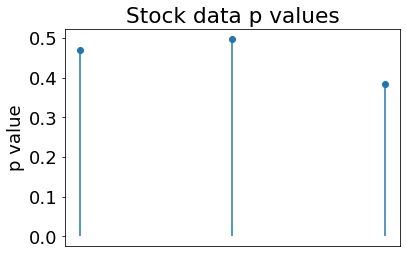

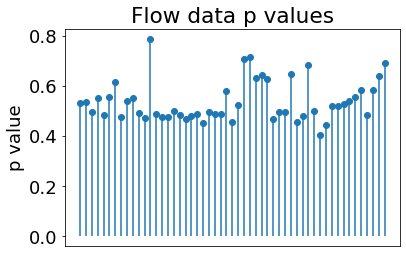

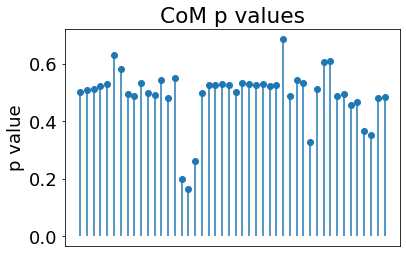

check stock data coverage
[[-45.51389408 -29.80742412 -37.2          1.        ]
 [  6.65311825  10.69524177   8.6          1.        ]
 [ 13.66094916  23.0985957   19.16         1.        ]]
check flow data coverage
[[2.97059651e+01 4.51761469e+01 3.72000000e+01 1.00000000e+00]
 [2.83927486e+01 4.30849261e+01 3.54000000e+01 1.00000000e+00]
 [1.29208147e+00 2.27244939e+00 1.80000000e+00 1.00000000e+00]
 [2.37999575e+01 3.64269641e+01 2.98000000e+01 1.00000000e+00]
 [4.09228956e+00 7.01499066e+00 5.60000000e+00 1.00000000e+00]
 [2.36334295e+01 3.61469420e+01 2.97000000e+01 1.00000000e+00]
 [1.06624943e-05 3.31012855e-01 1.00000000e-01 1.00000000e+00]
 [2.83250227e-05 4.21088908e-01 2.00000000e-01 1.00000000e+00]
 [7.33523235e-01 1.28259728e+00 1.00000000e+00 1.00000000e+00]
 [5.44699663e-01 1.09161634e+00 8.00000000e-01 1.00000000e+00]
 [9.37903158e-01 1.65638788e+00 1.30000000e+00 1.00000000e+00]
 [2.32861324e+00 4.05728467e+00 3.20000000e+00 1.00000000e+00]
 [3.46370644e-05 2.48160398

C:\Users\Junyang Wang\BayesianMFAmodel0712\aluminiummodel\posteriorpredictive.py:59: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  stock_hdi = az.hdi(posterior_pred['stockdata'], hdi_prob=0.95)
C:\Users\Junyang Wang\BayesianMFAmodel0712\aluminiummodel\posteriorpredictive.py:60: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  flow_hdi = az.hdi(posterior_pred['flowdata'], hdi_prob=0.95)
C:\Users\Junyang Wang\BayesianMFAmodel0712\aluminiummodel\posteriorpredictive.py:61: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  CoM_hdi = az.hdi(posterior_pred['CoM'], hdi_prob=0.95)


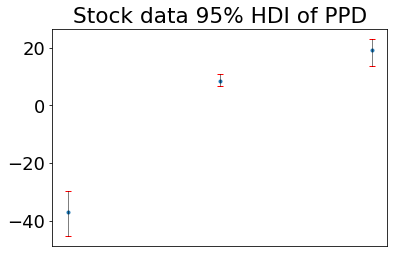

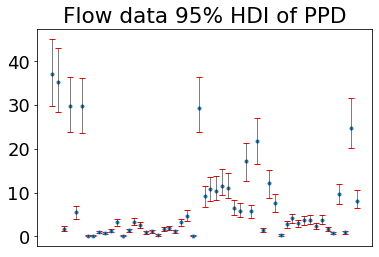

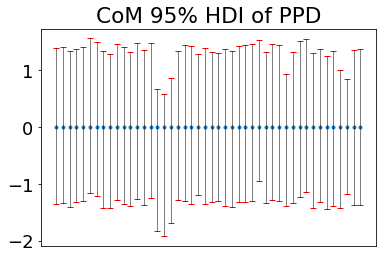

In [10]:
#plot posterior predictive 95% HDI and p values, for flow and change in stock data, and CoM conditions.

ppplots(posterior_pred,datavector,stockindex,flowindex,CoMindex,useratiodata)

In [11]:
#plot posterior predictive 95% HDI and p values, for ratio data, scenario B only.

ppplotsratiodata(posterior_pred,ratiovector,useratiodata)

KeyError: 'ratiodata'

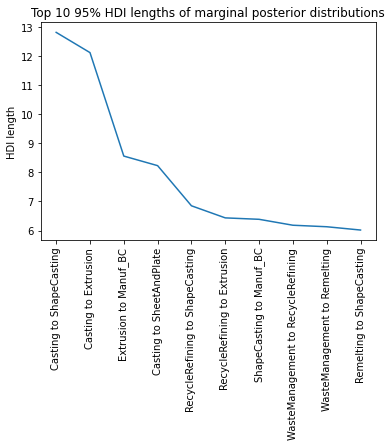

In [12]:
#plot top 10 widths of marginal posterior 95% HDI

ci_95_length=top10hdi(trace,processnamesdict,availablechildstocksandflows,useratiodata,m)

In [13]:
print(np.mean(ci_95_length))
print(np.max(ci_95_length))
print(np.min(ci_95_length))
print(np.shape(ci_95_length))

2.3124148186286715
12.831377758490477
0.14555127192622572
(179,)


In [14]:
trace.to_netcdf("model"+filelabeler(useratiodata)+".nc")

'modelscenarioA.nc'

In [ ]:
print("model"+filelabeler(useratiodata)+".nc")
trace = az.from_netcdf("model"+filelabeler(useratiodata)+".nc")